In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, LSTM, GRU, RNN, L1Loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from logger import init_logging
from base_module import MModule
from data import MDataset, Graph, load_graphs
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, GraphNode, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, pad_np_vectors
import base_module
from executor import single_train_loop, nested_detach, grid_search_loop
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging, logging
import logger
import gcn
from gcn import GCNLayer
import transformer
from transformer import TransformerModel
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
reload(gcn)
reload(transformer)
init_logging()

datasets_path: /root/guohao/DLT-perf-model/datasets
configs_path: /root/guohao/DLT-perf-model/notebooks/configs
datasets_path: /root/guohao/DLT-perf-model/datasets
configs_path: /root/guohao/DLT-perf-model/notebooks/configs


In [3]:
dataset_environment_str = "P4_CPUALL"
scaler_cls = StandardScaler  # MinMaxScaler
dummy = False
model_type = ModelType.LSTM
method_prefix = "SubgraphBased"
eval_size = 200_000
train_size = 1000_000
epoch = 50
eval_step = 5000
# T4_CPUALL
meta_model_path = 'ckpts/meta/LSTM/meta_train2024-01-04_17-19-49/ckpt_900.pth'
scalers = None
eval_graphs = None
transfer_configs = [
    # {
    #     "greeze_layers": [1, 3],
    #     "reinit_proj": True
    # },
    # {
    #     "greeze_layers": [1, 3],
    #     "reinit_proj": False
    # },
    {
        "greeze_layers": [2, 4],
        "reinit_proj": True
    },
    # {
    #     "greeze_layers": [2, 4],
    #     "reinit_proj": False
    # },
    # {
    #     "greeze_layers": [1, 2],
    #     "reinit_proj": True
    # },
    # {
    #     "greeze_layers": [1, 2],
    #     "reinit_proj": False
    # },
    # {
    #     "greeze_layers": [3, 4],
    #     "reinit_proj": True
    # },
    # {
    #     "greeze_layers": [3, 4],
    #     "reinit_proj": False
    # }
]

In [4]:
def get_scalers(raw_train_ds: MDataset):

    def _preprocess_required_data(ds: MDataset):
        x_subgraph_feature_array = list()
        y_nodes_durations_array = list()
        y_subgraph_durations_array = list()

        for data in ds:
            feature, label = data
            x_subgraph_feature = feature["x_subgraph_feature"]
            assert isinstance(x_subgraph_feature, list)
            x_subgraph_feature_array.extend(x_subgraph_feature)

            y_nodes_durations = label["y_nodes_durations"]
            assert isinstance(y_nodes_durations, list)
            y_nodes_durations_array.extend(y_nodes_durations)

            y_subgraph_durations = label["y_subgraph_durations"]
            y_subgraph_durations_array.append(y_subgraph_durations)

        x_subgraph_feature_array = np.array(x_subgraph_feature_array)
        y_nodes_durations_array = np.array(y_nodes_durations_array)
        y_subgraph_durations_array = np.array(y_subgraph_durations_array)
        return [x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array]

    x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array = _preprocess_required_data(
        ds=raw_train_ds)

    x_subgraph_feature_scaler = scaler_cls()
    x_subgraph_feature_scaler.fit(x_subgraph_feature_array)

    y_nodes_durations_scaler = scaler_cls()
    y_nodes_durations_scaler.fit(y_nodes_durations_array)

    y_subgraph_durations_scaler = scaler_cls()
    y_subgraph_durations_scaler.fit(y_subgraph_durations_array)

    return x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler


def subgraph_features(graph: Graph, subgraph_node_size: int = 10, step: int = 5, dataset_params: Dict = {}) -> \
        Tuple[List[Dict], List[Dict]]:
    subgraphs, _ = graph.subgraphs(
        subgraph_node_size=subgraph_node_size, step=step)
    X, Y = list(), list()

    def subgraph_feature(nodes: List[GraphNode]):
        feature_matrix = list()
        for node in nodes:
            feature = node.op.to_feature_array(
                mode=dataset_params.get("mode", "complex"))
            feature = np.array(feature)
            feature_matrix.append(feature)

        feature_matrix = pad_np_vectors(feature_matrix)
        feature_matrix = np.array(feature_matrix)

        adj_matrix = [
            [0.] * len(nodes) for _ in range(len(nodes))
        ]
        for curr_idx, node in enumerate(nodes):
            if curr_idx + 1 < len(nodes):
                adj_matrix[curr_idx][curr_idx+1] = 1.

        adj_matrix = np.array(adj_matrix)
        # x
        feature = {
            "x_graph_id": graph.ID,
            "x_node_ids": "|".join([str(node.node_id) for node in nodes]),
            "x_subgraph_feature": feature_matrix,
            "x_adj_matrix": adj_matrix
        }

        # y
        subgraph_duration = sum(node.duration + node.gap for node in subgraph)
        nodes_durations = list()
        for node in subgraph:
            node_duration_label = (
                node.duration, node.gap
            )
            nodes_durations.append(node_duration_label)

        label = {
            "y_graph_id": graph.ID,
            "y_nodes_durations": nodes_durations,
            "y_subgraph_durations": (subgraph_duration,)
        }

        return feature, label

    for i, subgraph in enumerate(subgraphs):
        x, y = subgraph_feature(subgraph)
        X.append(x)
        Y.append(y)

    return X, Y


def init_dataset(graphs: List[Graph], conf) -> MDataset:
    X = list()
    Y = list()

    subgraph_feature_maxsize = 0

    for graph in graphs:
        X_, Y_ = subgraph_features(graph=graph,
                                   subgraph_node_size=conf.dataset_subgraph_node_size,
                                   step=conf.dataset_subgraph_step,
                                   dataset_params=conf.dataset_params)
        for x in X_:
            subgraph_feature_size = len(x["x_subgraph_feature"][0])
            subgraph_feature_maxsize = max(
                subgraph_feature_maxsize, subgraph_feature_size)

        X.extend(X_)
        Y.extend(Y_)

    for x in X:
        x["x_subgraph_feature"] = pad_np_vectors(
            x["x_subgraph_feature"], maxsize=subgraph_feature_maxsize)

    dataset = MDataset(X, Y)
    return dataset

In [5]:

def preprocess_dataset(ds: MDataset, scalers) -> MDataset:
    x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

    processed_features = list()
    processed_labels = list()

    for data in ds:
        feature, label = data
        x_subgraph_feature = feature["x_subgraph_feature"]
        assert isinstance(x_subgraph_feature, list)
        x_subgraph_feature = np.array(x_subgraph_feature).astype(np.float32)
        transformed_x_subgraph_feature = x_subgraph_feature_scaler.transform(
            x_subgraph_feature)

        x_adj_matrix = feature["x_adj_matrix"]
        x_adj_matrix = np.array(x_adj_matrix).astype(np.float32)

        y_nodes_durations = label["y_nodes_durations"]
        assert isinstance(y_nodes_durations, list)
        y_nodes_durations = np.array(y_nodes_durations).astype(np.float32)
        transformed_y_nodes_durations = y_nodes_durations_scaler.transform(
            y_nodes_durations)

        y_subgraph_durations = label["y_subgraph_durations"]
        y_subgraph_durations_array = (y_subgraph_durations,)
        y_subgraph_durations_array = y_subgraph_durations_scaler.transform(
            y_subgraph_durations_array)
        transformed_y_subgraph_durations = y_subgraph_durations_array[0]

        processed_features.append({
            "x_graph_id": feature["x_graph_id"],
            "x_node_ids": feature["x_node_ids"],
            "x_subgraph_feature": torch.Tensor(transformed_x_subgraph_feature),
            "x_adj_matrix": torch.Tensor(x_adj_matrix)
        })

        processed_labels.append({
            "y_graph_id": label["y_graph_id"],
            "y_nodes_durations": torch.Tensor(transformed_y_nodes_durations),
            "y_subgraph_durations": torch.Tensor(transformed_y_subgraph_durations)
        })

    ds = MDataset(processed_features, processed_labels)
    return ds

In [6]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    def compute_graph_nodes_durations(outputs_, node_ids_str_):
        x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers
        node_to_durations = defaultdict(list)
        for i, output_ in enumerate(outputs_):
            node_ids = node_ids_str_[i]
            node_ids_ = node_ids.split("|")
            assert len(output_) == len(node_ids_)
            transformed: np.ndarray = y_nodes_durations_scaler.inverse_transform(
                output_)
            for i, node_id in enumerate(node_ids_):
                node_to_durations[node_id].append(np.sum(transformed[i]))
        node_to_duration = {k: np.average(v)
                            for k, v in node_to_durations.items()}
        return node_to_duration

    graph_id_to_node_to_duration = defaultdict(lambda: defaultdict(list))
    for inputs, outputs in zip(input_batches, output_batches):
        outputs = nested_detach(outputs)
        outputs = outputs.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        graph_groups = defaultdict(list)
        for i, graph_id in enumerate(graph_ids):
            graph_groups[graph_id].append(i)

        for graph_id, indices in graph_groups.items():
            group_x_node_ids = [v for i, v in enumerate(
                inputs["x_node_ids"]) if i in indices]
            group_outputs = [v for i, v in enumerate(outputs) if i in indices]
            node_to_durations = compute_graph_nodes_durations(
                group_outputs, group_x_node_ids)
            for node, duration in node_to_durations.items():
                graph_id_to_node_to_duration[graph_id][node].append(duration)
    graph_id_to_duration_pred = dict()
    # TODO check this!!!
    for graph_id, node_to_duration in graph_id_to_node_to_duration.items():
        duration_pred = 0
        for _, duration_preds in node_to_duration.items():
            duration_pred += np.average(duration_preds)
        graph_id_to_duration_pred[graph_id] = duration_pred
    duration_metrics = MetricUtil.compute_duration_metrics(
        eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}

In [7]:

def to_device(conf: Config, features, labels):
    features['x_subgraph_feature'] = features['x_subgraph_feature'].to(
        conf.device)
    features['x_adj_matrix'] = features['x_adj_matrix'].to(conf.device)
    labels['y_nodes_durations'] = labels['y_nodes_durations'].to(conf.device)
    labels['y_subgraph_durations'] = labels['y_subgraph_durations'].to(
        conf.device)
    return features, labels

In [8]:

class LSTMModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, num_layers, bidirectional, **kwargs):
        super().__init__(**kwargs)
        self.lstm = LSTM(input_size=feature_size, hidden_size=feature_size, num_layers=num_layers, batch_first=True,
                         bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.project = torch.nn.Linear(
            in_features=feature_size * num_directions, out_features=nodes_durations_len)
        self.loss_fn = L1Loss()

    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "num_layers": [4, 6, 8],
            "bidirectional": [True, False],
            "learning_rate": [1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        X = X["x_subgraph_feature"]
        out, _ = self.lstm(X)
        Y = self.project(out)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss

    def prepare_transfer(self, freeze_layers: list | None = None, reinit_proj: bool = True, **kwargs):
        print("prepare_transfer")
        if freeze_layers is not None:
            layers = self.lstm.layers
            if freeze_layers > len(layers):
                raise ValueError(
                    f"freeze_layers ({freeze_layers}) must be less than the number of layers ")
            for layer_idx in range(freeze_layers):
                for param in layers[layer_idx].parameters():
                    param.requires_grad = False
        if reinit_proj:
            self.project.reset_parameters()


def init_LSTM_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "bidirectional": True,
        }
    x_node_feature_size = 66
    y_nodes_durations_len = 2
    print(x_node_feature_size, y_nodes_durations_len)
    model_params = {}
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    print(final_params)
    return LSTMModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )

In [9]:
conf = Config.from_dict({
    "model": "LSTM",
    "dataset_environment_str": dataset_environment_str,
    "meta_dataset_environment_strs": [dataset_environment_str],
    "dataset_subgraph_node_size": 12,
    "dataset_subgraph_step": 3,
    "all_seed": 42,
    "dataset_params": {
        "duration_summed": False,
    },
    "model_params": {
        "num_layers": 4,
        "bidirectional": True
    },
    "dataset_dummy": False,
    "batch_size": 128,
    "eval_steps": eval_step,
    "learning_rate": 0.001,
    "epochs": epoch,
    "optimizer": "Adam",
    "train_size": train_size,
    "eval_size": eval_size,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [dataset_environment_str],
        "meta_dataset_eval_environment_strs": [dataset_environment_str],
    },
})
eval_graphs = load_graphs(dataset_environment_str,
                          train_or_eval="eval",
                          use_dummy=dummy,
                          max_row=eval_size)
train_graphs = load_graphs(dataset_environment_str,
                           train_or_eval="train",
                           use_dummy=dummy,
                           max_row=train_size)  # todo 500
print(len(train_graphs), len(eval_graphs))
train_ds = init_dataset(train_graphs, conf)
eval_ds = init_dataset(eval_graphs, conf)
scalers = get_scalers(train_ds)
preprocessed_train_ds = preprocess_dataset(train_ds, scalers)
preprocessed_eval_ds = preprocess_dataset(eval_ds, scalers)

[2024-01-08 11:36:43,488] {data.py:448} INFO - Loading graphs eval
[2024-01-08 11:36:43,490] {data.py:419} INFO - Loading merged.csv
[2024-01-08 11:36:43,490] {data.py:419} INFO - Loading merged.csv
[2024-01-08 11:36:43,795] {data.py:422} INFO - Loaded merged.csv, 167196 rows
[2024-01-08 11:36:44,075] {data.py:428} INFO - Loaded shufflenet_v2_x0_5.181_7.csv, 849 rows
[2024-01-08 11:36:44,345] {data.py:428} INFO - Loaded shufflenet_v2_x1_5.88_7.csv, 847 rows
[2024-01-08 11:36:44,617] {data.py:428} INFO - Loaded shufflenet_v2_x1_5.159_7.csv, 849 rows
[2024-01-08 11:36:45,001] {data.py:428} INFO - Loaded rand_6000.144_7.csv, 1218 rows
[2024-01-08 11:36:45,272] {data.py:428} INFO - Loaded shufflenet_v2_x0_5.220_7.csv, 849 rows
[2024-01-08 11:36:45,493] {data.py:428} INFO - Loaded rand_5000.50_7.csv, 683 rows
[2024-01-08 11:36:45,863] {data.py:428} INFO - Loaded rand_3500.9_7.csv, 683 rows
[2024-01-08 11:36:46,132] {data.py:428} INFO - Loaded shufflenet_v2_x0_5.127_7.csv, 849 rows
[2024-01-

MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 11:42:54,986] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 11:42:54,987] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/1622 [00:00<?, ?it/s]

[2024-01-08 11:42:55,137] {executor.py:114} INFO - ModelType.LSTM trained for 0.151850087 seconds.
[2024-01-08 11:42:55,139] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 11:43:01,470] {executor.py:120} INFO - ModelType.LSTM train loss: 0.3560295104980469, eval metrics: {'eval_loss': 0.33155145084885473, 'MRE': 0.9969631374723833, 'MAE': 0.833339182825772, 'RMSE': 541.772147974475}
[2024-01-08 11:43:01,475] {executor.py:363} INFO - Saving model at step 0 with loss 0.3560295104980469,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:19<00:00, 85.20it/s] 

[2024-01-08 11:43:14,028] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1622/1622 [00:12<00:00, 132.46it/s]

[2024-01-08 11:43:26,278] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1622/1622 [00:12<00:00, 128.85it/s]

[2024-01-08 11:43:38,872] {executor.py:323} INFO - ModelType.LSTM training epoch 3



  8%|▊         | 131/1622 [00:00<00:11, 130.04it/s]

[2024-01-08 11:43:39,885] {executor.py:114} INFO - ModelType.LSTM trained for 44.899659417 seconds.
[2024-01-08 11:43:39,887] {executor.py:115} INFO - ModelType.LSTM eval at step 5000.
[2024-01-08 11:43:46,217] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05479001626372337, eval metrics: {'eval_loss': 0.06637363060749638, 'MRE': 0.07796154072997039, 'MAE': 0.07468025721404821, 'RMSE': 62.38313221723221}
[2024-01-08 11:43:46,221] {executor.py:363} INFO - Saving model at step 5000 with loss 0.05479001626372337,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 85.47it/s] 

[2024-01-08 11:43:57,853] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1622/1622 [00:12<00:00, 128.60it/s]

[2024-01-08 11:44:10,470] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1622/1622 [00:12<00:00, 128.24it/s]

[2024-01-08 11:44:23,123] {executor.py:323} INFO - ModelType.LSTM training epoch 6



 16%|█▌        | 263/1622 [00:02<00:10, 127.95it/s]

[2024-01-08 11:44:25,179] {executor.py:114} INFO - ModelType.LSTM trained for 90.193489918 seconds.
[2024-01-08 11:44:25,180] {executor.py:115} INFO - ModelType.LSTM eval at step 10000.
[2024-01-08 11:44:31,520] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04165768623352051, eval metrics: {'eval_loss': 0.06046698888893912, 'MRE': 0.06530829590655392, 'MAE': 0.058266485021912964, 'RMSE': 45.01185225407106}
[2024-01-08 11:44:31,525] {executor.py:363} INFO - Saving model at step 10000 with loss 0.04165768623352051,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 85.72it/s] 

[2024-01-08 11:44:42,049] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1622/1622 [00:12<00:00, 128.66it/s]

[2024-01-08 11:44:54,661] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1622/1622 [00:12<00:00, 128.58it/s]

[2024-01-08 11:45:07,281] {executor.py:323} INFO - ModelType.LSTM training epoch 9



 24%|██▍       | 397/1622 [00:02<00:09, 129.48it/s]

[2024-01-08 11:45:10,316] {executor.py:114} INFO - ModelType.LSTM trained for 135.330616149 seconds.
[2024-01-08 11:45:10,317] {executor.py:115} INFO - ModelType.LSTM eval at step 15000.
[2024-01-08 11:45:16,654] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05234792083501816, eval metrics: {'eval_loss': 0.058195774608391704, 'MRE': 0.06292240912234671, 'MAE': 0.06719482654400637, 'RMSE': 71.61186544743578}
[2024-01-08 11:45:16,659] {executor.py:363} INFO - Saving model at step 15000 with loss 0.05234792083501816,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 85.51it/s] 

[2024-01-08 11:45:26,254] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1622/1622 [00:12<00:00, 127.23it/s]

[2024-01-08 11:45:39,007] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1622/1622 [00:12<00:00, 128.43it/s]

[2024-01-08 11:45:51,641] {executor.py:323} INFO - ModelType.LSTM training epoch 12



 32%|███▏      | 526/1622 [00:04<00:08, 124.71it/s]

[2024-01-08 11:45:55,749] {executor.py:114} INFO - ModelType.LSTM trained for 180.763572956 seconds.
[2024-01-08 11:45:55,750] {executor.py:115} INFO - ModelType.LSTM eval at step 20000.
[2024-01-08 11:46:02,192] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05379251763224602, eval metrics: {'eval_loss': 0.05403348309460836, 'MRE': 0.057781431896877164, 'MAE': 0.052869776472471035, 'RMSE': 41.164036304367045}
[2024-01-08 11:46:02,196] {executor.py:363} INFO - Saving model at step 20000 with loss 0.05379251763224602,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 85.45it/s] 

[2024-01-08 11:46:10,626] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1622/1622 [00:12<00:00, 134.82it/s]

[2024-01-08 11:46:22,662] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1622/1622 [00:11<00:00, 136.07it/s]

[2024-01-08 11:46:34,587] {executor.py:323} INFO - ModelType.LSTM training epoch 15



 41%|████      | 660/1622 [00:04<00:07, 136.18it/s]

[2024-01-08 11:46:39,416] {executor.py:114} INFO - ModelType.LSTM trained for 224.430082567 seconds.
[2024-01-08 11:46:39,417] {executor.py:115} INFO - ModelType.LSTM eval at step 25000.
[2024-01-08 11:46:45,736] {executor.py:120} INFO - ModelType.LSTM train loss: 0.043683409690856934, eval metrics: {'eval_loss': 0.05381050954918876, 'MRE': 0.05026729718044436, 'MAE': 0.04755062020965541, 'RMSE': 39.6431900461926}
[2024-01-08 11:46:45,740] {executor.py:363} INFO - Saving model at step 25000 with loss 0.043683409690856934,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 89.52it/s] 

[2024-01-08 11:46:52,712] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1622/1622 [00:11<00:00, 138.87it/s]

[2024-01-08 11:47:04,396] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1622/1622 [00:11<00:00, 136.88it/s]

[2024-01-08 11:47:16,250] {executor.py:323} INFO - ModelType.LSTM training epoch 18



 49%|████▉     | 797/1622 [00:05<00:06, 136.88it/s]

[2024-01-08 11:47:22,139] {executor.py:114} INFO - ModelType.LSTM trained for 267.153171342 seconds.
[2024-01-08 11:47:22,140] {executor.py:115} INFO - ModelType.LSTM eval at step 30000.
[2024-01-08 11:47:28,503] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06611892580986023, eval metrics: {'eval_loss': 0.05428334427838844, 'MRE': 0.05278885277631663, 'MAE': 0.0526030442685236, 'RMSE': 43.62004186185049}
[2024-01-08 11:47:28,508] {executor.py:363} INFO - Saving model at step 30000 with loss 0.06611892580986023,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 89.01it/s] 

[2024-01-08 11:47:34,478] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1622/1622 [00:11<00:00, 135.73it/s]

[2024-01-08 11:47:46,433] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 1622/1622 [00:11<00:00, 136.84it/s]

[2024-01-08 11:47:58,290] {executor.py:323} INFO - ModelType.LSTM training epoch 21



 58%|█████▊    | 934/1622 [00:06<00:05, 135.78it/s]

[2024-01-08 11:48:05,063] {executor.py:114} INFO - ModelType.LSTM trained for 310.07712669 seconds.
[2024-01-08 11:48:05,064] {executor.py:115} INFO - ModelType.LSTM eval at step 35000.
[2024-01-08 11:48:11,401] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04291538521647453, eval metrics: {'eval_loss': 0.05057385955038147, 'MRE': 0.05251073153586812, 'MAE': 0.04840520030719222, 'RMSE': 38.249737923981506}
[2024-01-08 11:48:11,406] {executor.py:363} INFO - Saving model at step 35000 with loss 0.04291538521647453,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 89.86it/s] 

[2024-01-08 11:48:16,345] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 1622/1622 [00:12<00:00, 130.54it/s]

[2024-01-08 11:48:28,774] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 1622/1622 [00:12<00:00, 127.33it/s]

[2024-01-08 11:48:41,518] {executor.py:323} INFO - ModelType.LSTM training epoch 24



 66%|██████▌   | 1064/1622 [00:08<00:04, 128.74it/s]

[2024-01-08 11:48:49,828] {executor.py:114} INFO - ModelType.LSTM trained for 354.842530114 seconds.
[2024-01-08 11:48:49,829] {executor.py:115} INFO - ModelType.LSTM eval at step 40000.
[2024-01-08 11:48:56,154] {executor.py:120} INFO - ModelType.LSTM train loss: 0.08516585826873779, eval metrics: {'eval_loss': 0.053089701251974264, 'MRE': 0.0551093866073805, 'MAE': 0.056361593165533234, 'RMSE': 48.19666623790199}
[2024-01-08 11:48:56,159] {executor.py:363} INFO - Saving model at step 40000 with loss 0.08516585826873779,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 85.80it/s] 

[2024-01-08 11:49:00,427] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 1622/1622 [00:12<00:00, 128.48it/s]

[2024-01-08 11:49:13,057] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 1622/1622 [00:12<00:00, 128.98it/s]

[2024-01-08 11:49:25,638] {executor.py:323} INFO - ModelType.LSTM training epoch 27



 74%|███████▎  | 1194/1622 [00:09<00:03, 128.64it/s]

[2024-01-08 11:49:35,215] {executor.py:114} INFO - ModelType.LSTM trained for 400.22898648 seconds.
[2024-01-08 11:49:35,216] {executor.py:115} INFO - ModelType.LSTM eval at step 45000.
[2024-01-08 11:49:44,208] {executor.py:120} INFO - ModelType.LSTM train loss: 0.061053138226270676, eval metrics: {'eval_loss': 0.053005234258223594, 'MRE': 0.05037827760659489, 'MAE': 0.047628353938867225, 'RMSE': 38.05838464378735}
[2024-01-08 11:49:44,215] {executor.py:363} INFO - Saving model at step 45000 with loss 0.061053138226270676,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:21<00:00, 74.39it/s] 

[2024-01-08 11:49:47,446] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 1622/1622 [00:12<00:00, 128.40it/s]

[2024-01-08 11:50:00,082] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 1622/1622 [00:12<00:00, 128.45it/s]

[2024-01-08 11:50:12,714] {executor.py:323} INFO - ModelType.LSTM training epoch 30



 82%|████████▏ | 1331/1622 [00:10<00:02, 128.55it/s]

[2024-01-08 11:50:23,135] {executor.py:114} INFO - ModelType.LSTM trained for 448.149635425 seconds.
[2024-01-08 11:50:23,137] {executor.py:115} INFO - ModelType.LSTM eval at step 50000.
[2024-01-08 11:50:29,508] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04705170914530754, eval metrics: {'eval_loss': 0.0507243866901834, 'MRE': 0.04879828540728757, 'MAE': 0.044221357643887266, 'RMSE': 37.47047166583432}
[2024-01-08 11:50:29,513] {executor.py:363} INFO - Saving model at step 50000 with loss 0.04705170914530754,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 85.49it/s] 

[2024-01-08 11:50:31,692] {executor.py:323} INFO - ModelType.LSTM training epoch 31



100%|██████████| 1622/1622 [00:12<00:00, 128.31it/s]

[2024-01-08 11:50:44,338] {executor.py:323} INFO - ModelType.LSTM training epoch 32



100%|██████████| 1622/1622 [00:12<00:00, 129.26it/s]

[2024-01-08 11:50:56,891] {executor.py:323} INFO - ModelType.LSTM training epoch 33



 91%|█████████ | 1473/1622 [00:11<00:01, 128.45it/s]

[2024-01-08 11:51:08,360] {executor.py:114} INFO - ModelType.LSTM trained for 493.373993377 seconds.
[2024-01-08 11:51:08,361] {executor.py:115} INFO - ModelType.LSTM eval at step 55000.
[2024-01-08 11:51:14,715] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04220396280288696, eval metrics: {'eval_loss': 0.051124965303077946, 'MRE': 0.055361491640459004, 'MAE': 0.054164203700107806, 'RMSE': 46.62172007674221}
[2024-01-08 11:51:14,719] {executor.py:363} INFO - Saving model at step 55000 with loss 0.04220396280288696,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 85.60it/s] 

[2024-01-08 11:51:15,843] {executor.py:323} INFO - ModelType.LSTM training epoch 34



100%|██████████| 1622/1622 [00:12<00:00, 129.56it/s]

[2024-01-08 11:51:28,366] {executor.py:323} INFO - ModelType.LSTM training epoch 35



100%|██████████| 1622/1622 [00:12<00:00, 129.22it/s]

[2024-01-08 11:51:40,922] {executor.py:323} INFO - ModelType.LSTM training epoch 36



 98%|█████████▊| 1596/1622 [00:11<00:00, 139.82it/s]

[2024-01-08 11:51:52,714] {executor.py:114} INFO - ModelType.LSTM trained for 537.728211274 seconds.
[2024-01-08 11:51:52,715] {executor.py:115} INFO - ModelType.LSTM eval at step 60000.
[2024-01-08 11:51:59,071] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04309886321425438, eval metrics: {'eval_loss': 0.049701143811173486, 'MRE': 0.046582257418216436, 'MAE': 0.044999873888162435, 'RMSE': 38.474860652195744}
[2024-01-08 11:51:59,075] {executor.py:363} INFO - Saving model at step 60000 with loss 0.04309886321425438,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 88.70it/s] 

[2024-01-08 11:51:59,212] {executor.py:323} INFO - ModelType.LSTM training epoch 37



100%|██████████| 1622/1622 [00:11<00:00, 137.33it/s]

[2024-01-08 11:52:11,027] {executor.py:323} INFO - ModelType.LSTM training epoch 38



100%|██████████| 1622/1622 [00:11<00:00, 137.34it/s]

[2024-01-08 11:52:22,841] {executor.py:323} INFO - ModelType.LSTM training epoch 39



100%|██████████| 1622/1622 [00:11<00:00, 135.99it/s]

[2024-01-08 11:52:34,773] {executor.py:323} INFO - ModelType.LSTM training epoch 40



  7%|▋         | 110/1622 [00:00<00:10, 142.06it/s]

[2024-01-08 11:52:35,612] {executor.py:114} INFO - ModelType.LSTM trained for 580.626459561 seconds.
[2024-01-08 11:52:35,613] {executor.py:115} INFO - ModelType.LSTM eval at step 65000.
[2024-01-08 11:52:41,991] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04988318309187889, eval metrics: {'eval_loss': 0.04915569984576827, 'MRE': 0.04743887983584078, 'MAE': 0.04738809356023829, 'RMSE': 41.625606397590616}
[2024-01-08 11:52:41,996] {executor.py:363} INFO - Saving model at step 65000 with loss 0.04988318309187889,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:18<00:00, 88.72it/s] 

[2024-01-08 11:52:53,061] {executor.py:323} INFO - ModelType.LSTM training epoch 41



100%|██████████| 1622/1622 [00:12<00:00, 130.26it/s]

[2024-01-08 11:53:05,517] {executor.py:323} INFO - ModelType.LSTM training epoch 42



100%|██████████| 1622/1622 [00:12<00:00, 127.55it/s]

[2024-01-08 11:53:18,238] {executor.py:323} INFO - ModelType.LSTM training epoch 43



 16%|█▌        | 254/1622 [00:01<00:10, 127.91it/s]

[2024-01-08 11:53:20,215] {executor.py:114} INFO - ModelType.LSTM trained for 625.229916273 seconds.
[2024-01-08 11:53:20,217] {executor.py:115} INFO - ModelType.LSTM eval at step 70000.
[2024-01-08 11:53:26,596] {executor.py:120} INFO - ModelType.LSTM train loss: 0.049630314111709595, eval metrics: {'eval_loss': 0.05127989406687773, 'MRE': 0.04606741854469944, 'MAE': 0.04533484195075083, 'RMSE': 39.12246537173639}
[2024-01-08 11:53:26,600] {executor.py:363} INFO - Saving model at step 70000 with loss 0.049630314111709595,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:19<00:00, 84.78it/s] 

[2024-01-08 11:53:37,374] {executor.py:323} INFO - ModelType.LSTM training epoch 44



100%|██████████| 1622/1622 [00:12<00:00, 127.38it/s]

[2024-01-08 11:53:50,111] {executor.py:323} INFO - ModelType.LSTM training epoch 45



100%|██████████| 1622/1622 [00:12<00:00, 127.58it/s]

[2024-01-08 11:54:02,829] {executor.py:323} INFO - ModelType.LSTM training epoch 46



 24%|██▎       | 384/1622 [00:02<00:09, 126.71it/s]

[2024-01-08 11:54:05,862] {executor.py:114} INFO - ModelType.LSTM trained for 670.876926846 seconds.
[2024-01-08 11:54:05,864] {executor.py:115} INFO - ModelType.LSTM eval at step 75000.
[2024-01-08 11:54:12,263] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03788735717535019, eval metrics: {'eval_loss': 0.0511910952072468, 'MRE': 0.05618294415616893, 'MAE': 0.05071432406329383, 'RMSE': 41.67650818351579}
[2024-01-08 11:54:12,268] {executor.py:363} INFO - Saving model at step 75000 with loss 0.03788735717535019,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:19<00:00, 84.83it/s] 

[2024-01-08 11:54:21,954] {executor.py:323} INFO - ModelType.LSTM training epoch 47



100%|██████████| 1622/1622 [00:12<00:00, 127.85it/s]

[2024-01-08 11:54:34,644] {executor.py:323} INFO - ModelType.LSTM training epoch 48



100%|██████████| 1622/1622 [00:12<00:00, 126.38it/s]

[2024-01-08 11:54:47,483] {executor.py:323} INFO - ModelType.LSTM training epoch 49



 32%|███▏      | 518/1622 [00:04<00:08, 126.55it/s]

[2024-01-08 11:54:51,580] {executor.py:114} INFO - ModelType.LSTM trained for 716.594393544 seconds.
[2024-01-08 11:54:51,581] {executor.py:115} INFO - ModelType.LSTM eval at step 80000.
[2024-01-08 11:54:57,959] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03835359215736389, eval metrics: {'eval_loss': 0.0497792904467473, 'MRE': 0.04822860675226292, 'MAE': 0.0450538393508753, 'RMSE': 39.99926318867168}
[2024-01-08 11:54:57,964] {executor.py:363} INFO - Saving model at step 80000 with loss 0.03835359215736389,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-42-54


100%|██████████| 1622/1622 [00:19<00:00, 84.46it/s] 


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 11:55:06,834] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 11:55:06,835] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/1622 [00:00<?, ?it/s]

[2024-01-08 11:55:06,851] {executor.py:114} INFO - ModelType.LSTM trained for 0.016881726 seconds.
[2024-01-08 11:55:06,852] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 11:55:13,251] {executor.py:120} INFO - ModelType.LSTM train loss: 0.13569770753383636, eval metrics: {'eval_loss': 0.16275045939013533, 'MRE': 0.36300503192413675, 'MAE': 0.36044467659040513, 'RMSE': 269.7392867453028}
[2024-01-08 11:55:13,256] {executor.py:363} INFO - Saving model at step 0 with loss 0.13569770753383636,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:19<00:00, 84.18it/s] 

[2024-01-08 11:55:26,106] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1622/1622 [00:12<00:00, 126.08it/s]

[2024-01-08 11:55:38,975] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1622/1622 [00:12<00:00, 127.28it/s]

[2024-01-08 11:55:51,722] {executor.py:323} INFO - ModelType.LSTM training epoch 3



  8%|▊         | 128/1622 [00:00<00:11, 133.77it/s]

[2024-01-08 11:55:52,737] {executor.py:114} INFO - ModelType.LSTM trained for 45.902490215 seconds.
[2024-01-08 11:55:52,738] {executor.py:115} INFO - ModelType.LSTM eval at step 5000.
[2024-01-08 11:55:59,196] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06772436201572418, eval metrics: {'eval_loss': 0.06747974967825986, 'MRE': 0.08706278635481282, 'MAE': 0.08381640039302779, 'RMSE': 61.57368164334623}
[2024-01-08 11:55:59,201] {executor.py:363} INFO - Saving model at step 5000 with loss 0.06772436201572418,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:19<00:00, 84.76it/s] 

[2024-01-08 11:56:10,863] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1622/1622 [00:12<00:00, 134.79it/s]

[2024-01-08 11:56:22,901] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1622/1622 [00:12<00:00, 134.92it/s]

[2024-01-08 11:56:34,928] {executor.py:323} INFO - ModelType.LSTM training epoch 6



 16%|█▌        | 259/1622 [00:01<00:10, 134.82it/s]

[2024-01-08 11:56:36,904] {executor.py:114} INFO - ModelType.LSTM trained for 90.069589632 seconds.
[2024-01-08 11:56:36,905] {executor.py:115} INFO - ModelType.LSTM eval at step 10000.
[2024-01-08 11:56:45,926] {executor.py:120} INFO - ModelType.LSTM train loss: 0.052837520837783813, eval metrics: {'eval_loss': 0.058941736091175666, 'MRE': 0.05708397125317739, 'MAE': 0.05450267330055885, 'RMSE': 49.68313318833724}
[2024-01-08 11:56:45,930] {executor.py:363} INFO - Saving model at step 10000 with loss 0.052837520837783813,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:21<00:00, 76.75it/s] 

[2024-01-08 11:56:56,066] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1622/1622 [00:12<00:00, 128.31it/s]

[2024-01-08 11:57:08,711] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1622/1622 [00:12<00:00, 126.97it/s]

[2024-01-08 11:57:21,490] {executor.py:323} INFO - ModelType.LSTM training epoch 9



 24%|██▍       | 396/1622 [00:03<00:09, 128.28it/s]

[2024-01-08 11:57:24,596] {executor.py:114} INFO - ModelType.LSTM trained for 137.762064706 seconds.
[2024-01-08 11:57:24,597] {executor.py:115} INFO - ModelType.LSTM eval at step 15000.
[2024-01-08 11:57:30,986] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06272619962692261, eval metrics: {'eval_loss': 0.055666093914699684, 'MRE': 0.05319214708225683, 'MAE': 0.0485973875405922, 'RMSE': 41.517379834539916}
[2024-01-08 11:57:30,991] {executor.py:363} INFO - Saving model at step 15000 with loss 0.06272619962692261,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:19<00:00, 85.33it/s] 

[2024-01-08 11:57:40,502] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1622/1622 [00:12<00:00, 128.87it/s]

[2024-01-08 11:57:53,092] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1622/1622 [00:12<00:00, 128.36it/s]

[2024-01-08 11:58:05,732] {executor.py:323} INFO - ModelType.LSTM training epoch 12



 33%|███▎      | 530/1622 [00:04<00:08, 135.58it/s]

[2024-01-08 11:58:09,830] {executor.py:114} INFO - ModelType.LSTM trained for 182.995978637 seconds.
[2024-01-08 11:58:09,831] {executor.py:115} INFO - ModelType.LSTM eval at step 20000.
[2024-01-08 11:58:16,254] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05909748002886772, eval metrics: {'eval_loss': 0.05642839856999636, 'MRE': 0.05393317687546359, 'MAE': 0.05116879151195026, 'RMSE': 44.13946785029236}
[2024-01-08 11:58:16,259] {executor.py:363} INFO - Saving model at step 20000 with loss 0.05909748002886772,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:18<00:00, 85.93it/s] 

[2024-01-08 11:58:24,611] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1622/1622 [00:12<00:00, 127.80it/s]

[2024-01-08 11:58:37,307] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1622/1622 [00:12<00:00, 127.57it/s]

[2024-01-08 11:58:50,026] {executor.py:323} INFO - ModelType.LSTM training epoch 15



 41%|████      | 664/1622 [00:04<00:07, 133.85it/s]

[2024-01-08 11:58:55,023] {executor.py:114} INFO - ModelType.LSTM trained for 228.189380449 seconds.
[2024-01-08 11:58:55,025] {executor.py:115} INFO - ModelType.LSTM eval at step 25000.
[2024-01-08 11:59:01,348] {executor.py:120} INFO - ModelType.LSTM train loss: 0.07045671343803406, eval metrics: {'eval_loss': 0.05378960513308973, 'MRE': 0.05271969941154884, 'MAE': 0.04855460416354389, 'RMSE': 42.537470312155484}
[2024-01-08 11:59:01,353] {executor.py:363} INFO - Saving model at step 25000 with loss 0.07045671343803406,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:18<00:00, 88.15it/s] 

[2024-01-08 11:59:08,429] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1622/1622 [00:12<00:00, 134.48it/s]

[2024-01-08 11:59:20,495] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1622/1622 [00:12<00:00, 134.28it/s]

[2024-01-08 11:59:32,580] {executor.py:323} INFO - ModelType.LSTM training epoch 18



 49%|████▉     | 797/1622 [00:05<00:06, 127.79it/s]

[2024-01-08 11:59:38,528] {executor.py:114} INFO - ModelType.LSTM trained for 271.694146334 seconds.
[2024-01-08 11:59:38,529] {executor.py:115} INFO - ModelType.LSTM eval at step 30000.
[2024-01-08 11:59:44,901] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05556769296526909, eval metrics: {'eval_loss': 0.05278765455487359, 'MRE': 0.051802723686452376, 'MAE': 0.051603730883298844, 'RMSE': 46.82225265092413}
[2024-01-08 11:59:44,906] {executor.py:363} INFO - Saving model at step 30000 with loss 0.05556769296526909,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:18<00:00, 86.69it/s] 

[2024-01-08 11:59:51,296] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1622/1622 [00:11<00:00, 135.58it/s]

[2024-01-08 12:00:03,264] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 1622/1622 [00:12<00:00, 134.73it/s]

[2024-01-08 12:00:15,308] {executor.py:323} INFO - ModelType.LSTM training epoch 21



 57%|█████▋    | 925/1622 [00:06<00:05, 133.71it/s]

[2024-01-08 12:00:22,186] {executor.py:114} INFO - ModelType.LSTM trained for 315.352240017 seconds.
[2024-01-08 12:00:22,188] {executor.py:115} INFO - ModelType.LSTM eval at step 35000.
[2024-01-08 12:00:28,527] {executor.py:120} INFO - ModelType.LSTM train loss: 0.045953430235385895, eval metrics: {'eval_loss': 0.05176859764094834, 'MRE': 0.04857237301245889, 'MAE': 0.044638376191042856, 'RMSE': 37.5355237418815}
[2024-01-08 12:00:28,531] {executor.py:363} INFO - Saving model at step 35000 with loss 0.045953430235385895,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:18<00:00, 88.84it/s] 

[2024-01-08 12:00:33,570] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 1622/1622 [00:11<00:00, 135.58it/s]

[2024-01-08 12:00:45,538] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 1622/1622 [00:12<00:00, 127.46it/s]

[2024-01-08 12:00:58,268] {executor.py:323} INFO - ModelType.LSTM training epoch 24



 66%|██████▌   | 1064/1622 [00:08<00:04, 125.70it/s]

[2024-01-08 12:01:06,778] {executor.py:114} INFO - ModelType.LSTM trained for 359.943803861 seconds.
[2024-01-08 12:01:06,779] {executor.py:115} INFO - ModelType.LSTM eval at step 40000.
[2024-01-08 12:01:13,144] {executor.py:120} INFO - ModelType.LSTM train loss: 0.051645614206790924, eval metrics: {'eval_loss': 0.05090192297482153, 'MRE': 0.04688750553047104, 'MAE': 0.04437315939958175, 'RMSE': 39.18785710679108}
[2024-01-08 12:01:13,149] {executor.py:363} INFO - Saving model at step 40000 with loss 0.051645614206790924,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:19<00:00, 84.31it/s] 

[2024-01-08 12:01:17,512] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 1622/1622 [00:12<00:00, 128.00it/s]

[2024-01-08 12:01:30,188] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 1622/1622 [00:12<00:00, 128.14it/s]

[2024-01-08 12:01:42,851] {executor.py:323} INFO - ModelType.LSTM training epoch 27



 74%|███████▎  | 1193/1622 [00:09<00:03, 129.54it/s]

[2024-01-08 12:01:52,315] {executor.py:114} INFO - ModelType.LSTM trained for 405.481396222 seconds.
[2024-01-08 12:01:52,317] {executor.py:115} INFO - ModelType.LSTM eval at step 45000.
[2024-01-08 12:01:58,629] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05778324604034424, eval metrics: {'eval_loss': 0.054482773590406, 'MRE': 0.060460344828892766, 'MAE': 0.0634898809338188, 'RMSE': 56.76440478210923}
[2024-01-08 12:01:58,633] {executor.py:363} INFO - Saving model at step 45000 with loss 0.05778324604034424,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:19<00:00, 85.30it/s] 

[2024-01-08 12:02:01,871] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 1622/1622 [00:12<00:00, 127.86it/s]

[2024-01-08 12:02:14,561] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 1622/1622 [00:12<00:00, 125.58it/s]

[2024-01-08 12:02:27,481] {executor.py:323} INFO - ModelType.LSTM training epoch 30



 82%|████████▏ | 1337/1622 [00:10<00:02, 124.84it/s]

[2024-01-08 12:02:38,196] {executor.py:114} INFO - ModelType.LSTM trained for 451.361457256 seconds.
[2024-01-08 12:02:38,197] {executor.py:115} INFO - ModelType.LSTM eval at step 50000.
[2024-01-08 12:02:44,568] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05399869382381439, eval metrics: {'eval_loss': 0.04982668841175018, 'MRE': 0.048360164834116454, 'MAE': 0.0444458698209125, 'RMSE': 38.51733196707614}
[2024-01-08 12:02:44,573] {executor.py:363} INFO - Saving model at step 50000 with loss 0.05399869382381439,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:19<00:00, 83.83it/s] 

[2024-01-08 12:02:46,834] {executor.py:323} INFO - ModelType.LSTM training epoch 31



100%|██████████| 1622/1622 [00:12<00:00, 125.41it/s]

[2024-01-08 12:02:59,771] {executor.py:323} INFO - ModelType.LSTM training epoch 32



100%|██████████| 1622/1622 [00:12<00:00, 128.28it/s]

[2024-01-08 12:03:12,420] {executor.py:323} INFO - ModelType.LSTM training epoch 33



 90%|█████████ | 1462/1622 [00:11<00:01, 127.62it/s]

[2024-01-08 12:03:23,963] {executor.py:114} INFO - ModelType.LSTM trained for 497.128927589 seconds.
[2024-01-08 12:03:23,964] {executor.py:115} INFO - ModelType.LSTM eval at step 55000.
[2024-01-08 12:03:30,309] {executor.py:120} INFO - ModelType.LSTM train loss: 0.045572590082883835, eval metrics: {'eval_loss': 0.04903636561175937, 'MRE': 0.04731342561727276, 'MAE': 0.04320622545082538, 'RMSE': 37.75138031217411}
[2024-01-08 12:03:30,314] {executor.py:363} INFO - Saving model at step 55000 with loss 0.045572590082883835,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:19<00:00, 85.18it/s] 

[2024-01-08 12:03:31,466] {executor.py:323} INFO - ModelType.LSTM training epoch 34



100%|██████████| 1622/1622 [00:12<00:00, 128.01it/s]

[2024-01-08 12:03:44,142] {executor.py:323} INFO - ModelType.LSTM training epoch 35



100%|██████████| 1622/1622 [00:12<00:00, 128.33it/s]

[2024-01-08 12:03:56,785] {executor.py:323} INFO - ModelType.LSTM training epoch 36



 98%|█████████▊| 1596/1622 [00:12<00:00, 124.14it/s]

[2024-01-08 12:04:09,480] {executor.py:114} INFO - ModelType.LSTM trained for 542.64625764 seconds.
[2024-01-08 12:04:09,482] {executor.py:115} INFO - ModelType.LSTM eval at step 60000.
[2024-01-08 12:04:15,796] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03736255690455437, eval metrics: {'eval_loss': 0.0508859447033793, 'MRE': 0.051709149129872255, 'MAE': 0.04746463607695104, 'RMSE': 41.01841565717002}
[2024-01-08 12:04:15,801] {executor.py:363} INFO - Saving model at step 60000 with loss 0.03736255690455437,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:19<00:00, 84.66it/s] 

[2024-01-08 12:04:15,948] {executor.py:323} INFO - ModelType.LSTM training epoch 37



100%|██████████| 1622/1622 [00:12<00:00, 128.10it/s]

[2024-01-08 12:04:28,614] {executor.py:323} INFO - ModelType.LSTM training epoch 38



100%|██████████| 1622/1622 [00:12<00:00, 126.82it/s]

[2024-01-08 12:04:41,408] {executor.py:323} INFO - ModelType.LSTM training epoch 39



100%|██████████| 1622/1622 [00:12<00:00, 129.07it/s]

[2024-01-08 12:04:53,979] {executor.py:323} INFO - ModelType.LSTM training epoch 40



  7%|▋         | 117/1622 [00:00<00:11, 131.52it/s]

[2024-01-08 12:04:54,886] {executor.py:114} INFO - ModelType.LSTM trained for 588.051957371 seconds.
[2024-01-08 12:04:54,888] {executor.py:115} INFO - ModelType.LSTM eval at step 65000.
[2024-01-08 12:05:03,912] {executor.py:120} INFO - ModelType.LSTM train loss: 0.0439460352063179, eval metrics: {'eval_loss': 0.04755020436071162, 'MRE': 0.043826856255766024, 'MAE': 0.041337350469739326, 'RMSE': 37.38343550769446}
[2024-01-08 12:05:03,916] {executor.py:363} INFO - Saving model at step 65000 with loss 0.0439460352063179,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:21<00:00, 74.92it/s] 

[2024-01-08 12:05:15,633] {executor.py:323} INFO - ModelType.LSTM training epoch 41



100%|██████████| 1622/1622 [00:12<00:00, 128.37it/s]

[2024-01-08 12:05:28,273] {executor.py:323} INFO - ModelType.LSTM training epoch 42



100%|██████████| 1622/1622 [00:12<00:00, 127.79it/s]

[2024-01-08 12:05:40,971] {executor.py:323} INFO - ModelType.LSTM training epoch 43



 15%|█▌        | 245/1622 [00:01<00:10, 127.00it/s]

[2024-01-08 12:05:42,947] {executor.py:114} INFO - ModelType.LSTM trained for 636.113055659 seconds.
[2024-01-08 12:05:42,948] {executor.py:115} INFO - ModelType.LSTM eval at step 70000.
[2024-01-08 12:05:49,312] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04320337623357773, eval metrics: {'eval_loss': 0.04852306737411793, 'MRE': 0.045238618185957286, 'MAE': 0.04435888947271532, 'RMSE': 37.194385395650144}
[2024-01-08 12:05:49,316] {executor.py:363} INFO - Saving model at step 70000 with loss 0.04320337623357773,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:19<00:00, 84.97it/s] 

[2024-01-08 12:06:00,064] {executor.py:323} INFO - ModelType.LSTM training epoch 44



100%|██████████| 1622/1622 [00:12<00:00, 126.85it/s]

[2024-01-08 12:06:12,855] {executor.py:323} INFO - ModelType.LSTM training epoch 45



100%|██████████| 1622/1622 [00:12<00:00, 127.62it/s]

[2024-01-08 12:06:25,569] {executor.py:323} INFO - ModelType.LSTM training epoch 46



 24%|██▍       | 387/1622 [00:03<00:09, 126.21it/s]

[2024-01-08 12:06:28,602] {executor.py:114} INFO - ModelType.LSTM trained for 681.767994787 seconds.
[2024-01-08 12:06:28,603] {executor.py:115} INFO - ModelType.LSTM eval at step 75000.
[2024-01-08 12:06:34,926] {executor.py:120} INFO - ModelType.LSTM train loss: 0.036562055349349976, eval metrics: {'eval_loss': 0.051017695693078714, 'MRE': 0.05103696194339408, 'MAE': 0.04635216076411917, 'RMSE': 39.08575647462796}
[2024-01-08 12:06:34,931] {executor.py:363} INFO - Saving model at step 75000 with loss 0.036562055349349976,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:19<00:00, 85.02it/s] 

[2024-01-08 12:06:44,652] {executor.py:323} INFO - ModelType.LSTM training epoch 47



100%|██████████| 1622/1622 [00:12<00:00, 127.83it/s]

[2024-01-08 12:06:57,346] {executor.py:323} INFO - ModelType.LSTM training epoch 48



100%|██████████| 1622/1622 [00:12<00:00, 134.94it/s]

[2024-01-08 12:07:09,370] {executor.py:323} INFO - ModelType.LSTM training epoch 49



 32%|███▏      | 516/1622 [00:03<00:08, 130.96it/s]

[2024-01-08 12:07:13,282] {executor.py:114} INFO - ModelType.LSTM trained for 726.448403201 seconds.
[2024-01-08 12:07:13,284] {executor.py:115} INFO - ModelType.LSTM eval at step 80000.
[2024-01-08 12:07:19,606] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03891817480325699, eval metrics: {'eval_loss': 0.048334547013532875, 'MRE': 0.04804348050953357, 'MAE': 0.04536778701098861, 'RMSE': 38.1130112347123}
[2024-01-08 12:07:19,611] {executor.py:363} INFO - Saving model at step 80000 with loss 0.03891817480325699,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-55-06


100%|██████████| 1622/1622 [00:18<00:00, 87.93it/s] 


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 12:07:27,959] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 12:07:27,960] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/1622 [00:00<?, ?it/s]

[2024-01-08 12:07:27,975] {executor.py:114} INFO - ModelType.LSTM trained for 0.016316247 seconds.
[2024-01-08 12:07:27,977] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 12:07:34,314] {executor.py:120} INFO - ModelType.LSTM train loss: 0.30017170310020447, eval metrics: {'eval_loss': 0.2587993543328369, 'MRE': 0.468075430146194, 'MAE': 0.5110714937093083, 'RMSE': 422.2126504485063}
[2024-01-08 12:07:34,319] {executor.py:363} INFO - Saving model at step 0 with loss 0.30017170310020447,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:18<00:00, 86.70it/s] 

[2024-01-08 12:07:46,672] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1622/1622 [00:12<00:00, 128.32it/s]

[2024-01-08 12:07:59,317] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1622/1622 [00:12<00:00, 126.71it/s]

[2024-01-08 12:08:12,123] {executor.py:323} INFO - ModelType.LSTM training epoch 3



  8%|▊         | 124/1622 [00:00<00:11, 125.81it/s]

[2024-01-08 12:08:13,178] {executor.py:114} INFO - ModelType.LSTM trained for 45.21939352 seconds.
[2024-01-08 12:08:13,180] {executor.py:115} INFO - ModelType.LSTM eval at step 5000.
[2024-01-08 12:08:19,551] {executor.py:120} INFO - ModelType.LSTM train loss: 0.07784005999565125, eval metrics: {'eval_loss': 0.06976638657151664, 'MRE': 0.06780777985575925, 'MAE': 0.05949734910662633, 'RMSE': 45.31518090279059}
[2024-01-08 12:08:19,556] {executor.py:363} INFO - Saving model at step 5000 with loss 0.07784005999565125,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:19<00:00, 84.65it/s] 

[2024-01-08 12:08:31,288] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1622/1622 [00:12<00:00, 127.41it/s]

[2024-01-08 12:08:44,023] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1622/1622 [00:12<00:00, 127.86it/s]

[2024-01-08 12:08:56,713] {executor.py:323} INFO - ModelType.LSTM training epoch 6



 16%|█▌        | 259/1622 [00:02<00:10, 127.28it/s]

[2024-01-08 12:08:58,799] {executor.py:114} INFO - ModelType.LSTM trained for 90.840094884 seconds.
[2024-01-08 12:08:58,800] {executor.py:115} INFO - ModelType.LSTM eval at step 10000.
[2024-01-08 12:09:05,141] {executor.py:120} INFO - ModelType.LSTM train loss: 0.067414790391922, eval metrics: {'eval_loss': 0.060852779075704994, 'MRE': 0.06450252493747358, 'MAE': 0.05977642431589179, 'RMSE': 54.49273162733766}
[2024-01-08 12:09:05,146] {executor.py:363} INFO - Saving model at step 10000 with loss 0.067414790391922,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:19<00:00, 85.31it/s] 

[2024-01-08 12:09:15,732] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1622/1622 [00:12<00:00, 127.69it/s]

[2024-01-08 12:09:28,438] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1622/1622 [00:12<00:00, 127.19it/s]

[2024-01-08 12:09:41,195] {executor.py:323} INFO - ModelType.LSTM training epoch 9



 24%|██▍       | 394/1622 [00:02<00:08, 136.52it/s]

[2024-01-08 12:09:44,104] {executor.py:114} INFO - ModelType.LSTM trained for 136.144893517 seconds.
[2024-01-08 12:09:44,105] {executor.py:115} INFO - ModelType.LSTM eval at step 15000.
[2024-01-08 12:09:50,500] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05382687598466873, eval metrics: {'eval_loss': 0.05659814554094025, 'MRE': 0.05681176011052052, 'MAE': 0.05122661544835576, 'RMSE': 39.61491426243071}
[2024-01-08 12:09:50,505] {executor.py:363} INFO - Saving model at step 15000 with loss 0.05382687598466873,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:18<00:00, 88.29it/s] 

[2024-01-08 12:09:59,570] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1622/1622 [00:12<00:00, 134.87it/s]

[2024-01-08 12:10:11,601] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1622/1622 [00:12<00:00, 133.77it/s]

[2024-01-08 12:10:23,731] {executor.py:323} INFO - ModelType.LSTM training epoch 12



 32%|███▏      | 526/1622 [00:03<00:08, 134.25it/s]

[2024-01-08 12:10:27,697] {executor.py:114} INFO - ModelType.LSTM trained for 179.737908623 seconds.
[2024-01-08 12:10:27,698] {executor.py:115} INFO - ModelType.LSTM eval at step 20000.
[2024-01-08 12:10:34,030] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05627378821372986, eval metrics: {'eval_loss': 0.05685299444837737, 'MRE': 0.059229594361841255, 'MAE': 0.062470353746289495, 'RMSE': 68.43840061776551}
[2024-01-08 12:10:34,035] {executor.py:363} INFO - Saving model at step 20000 with loss 0.05627378821372986,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:18<00:00, 87.56it/s] 

[2024-01-08 12:10:42,261] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1622/1622 [00:12<00:00, 127.28it/s]

[2024-01-08 12:10:55,010] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1622/1622 [00:12<00:00, 126.44it/s]

[2024-01-08 12:11:07,842] {executor.py:323} INFO - ModelType.LSTM training epoch 15



 41%|████      | 659/1622 [00:05<00:07, 126.90it/s]

[2024-01-08 12:11:13,165] {executor.py:114} INFO - ModelType.LSTM trained for 225.205995652 seconds.
[2024-01-08 12:11:13,166] {executor.py:115} INFO - ModelType.LSTM eval at step 25000.
[2024-01-08 12:11:22,238] {executor.py:120} INFO - ModelType.LSTM train loss: 0.058734387159347534, eval metrics: {'eval_loss': 0.05654835431862356, 'MRE': 0.04737600563239969, 'MAE': 0.051985168062967296, 'RMSE': 47.41039930394685}
[2024-01-08 12:11:22,242] {executor.py:363} INFO - Saving model at step 25000 with loss 0.058734387159347534,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:21<00:00, 74.05it/s] 

[2024-01-08 12:11:29,751] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1622/1622 [00:12<00:00, 127.71it/s]

[2024-01-08 12:11:42,457] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1622/1622 [00:12<00:00, 125.89it/s]

[2024-01-08 12:11:55,345] {executor.py:323} INFO - ModelType.LSTM training epoch 18



 49%|████▉     | 794/1622 [00:04<00:02, 345.51it/s]

[2024-01-08 12:12:00,248] {executor.py:114} INFO - ModelType.LSTM trained for 272.289324664 seconds.
[2024-01-08 12:12:00,249] {executor.py:115} INFO - ModelType.LSTM eval at step 30000.
[2024-01-08 12:12:06,530] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04666970297694206, eval metrics: {'eval_loss': 0.056584955288109896, 'MRE': 0.052801582873992704, 'MAE': 0.05182535879358256, 'RMSE': 42.569773160671346}
[2024-01-08 12:12:06,535] {executor.py:363} INFO - Saving model at step 30000 with loss 0.04666970297694206,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:16<00:00, 101.23it/s]

[2024-01-08 12:12:11,372] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1622/1622 [00:12<00:00, 125.19it/s]

[2024-01-08 12:12:24,333] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 1622/1622 [00:12<00:00, 126.02it/s]

[2024-01-08 12:12:37,209] {executor.py:323} INFO - ModelType.LSTM training epoch 21



 58%|█████▊    | 936/1622 [00:07<00:05, 127.26it/s]

[2024-01-08 12:12:44,593] {executor.py:114} INFO - ModelType.LSTM trained for 316.633871752 seconds.
[2024-01-08 12:12:44,594] {executor.py:115} INFO - ModelType.LSTM eval at step 35000.
[2024-01-08 12:12:51,022] {executor.py:120} INFO - ModelType.LSTM train loss: 0.049614012241363525, eval metrics: {'eval_loss': 0.05356205602573859, 'MRE': 0.05483405718044097, 'MAE': 0.0501381201237334, 'RMSE': 42.08390136049783}
[2024-01-08 12:12:51,026] {executor.py:363} INFO - Saving model at step 35000 with loss 0.049614012241363525,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:19<00:00, 84.91it/s] 

[2024-01-08 12:12:56,318] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 1622/1622 [00:12<00:00, 127.35it/s]

[2024-01-08 12:13:09,059] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 1622/1622 [00:12<00:00, 128.64it/s]

[2024-01-08 12:13:21,673] {executor.py:323} INFO - ModelType.LSTM training epoch 24



 66%|██████▌   | 1064/1622 [00:08<00:04, 127.83it/s]

[2024-01-08 12:13:30,064] {executor.py:114} INFO - ModelType.LSTM trained for 362.105183341 seconds.
[2024-01-08 12:13:30,065] {executor.py:115} INFO - ModelType.LSTM eval at step 40000.
[2024-01-08 12:13:36,410] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04986971244215965, eval metrics: {'eval_loss': 0.05036910991183069, 'MRE': 0.04876103125831565, 'MAE': 0.05123283420715729, 'RMSE': 42.88979158545669}
[2024-01-08 12:13:36,414] {executor.py:363} INFO - Saving model at step 40000 with loss 0.04986971244215965,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:19<00:00, 85.06it/s] 

[2024-01-08 12:13:40,746] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 1622/1622 [00:12<00:00, 127.76it/s]

[2024-01-08 12:13:53,446] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 1622/1622 [00:12<00:00, 127.53it/s]

[2024-01-08 12:14:06,169] {executor.py:323} INFO - ModelType.LSTM training epoch 27



 74%|███████▎  | 1196/1622 [00:09<00:03, 127.62it/s]

[2024-01-08 12:14:15,656] {executor.py:114} INFO - ModelType.LSTM trained for 407.697022082 seconds.
[2024-01-08 12:14:15,657] {executor.py:115} INFO - ModelType.LSTM eval at step 45000.
[2024-01-08 12:14:22,040] {executor.py:120} INFO - ModelType.LSTM train loss: 0.050686340779066086, eval metrics: {'eval_loss': 0.04871066978903526, 'MRE': 0.049038057820558964, 'MAE': 0.04605843349517757, 'RMSE': 37.31225972808611}
[2024-01-08 12:14:22,045] {executor.py:363} INFO - Saving model at step 45000 with loss 0.050686340779066086,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:19<00:00, 84.74it/s] 

[2024-01-08 12:14:25,315] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 1622/1622 [00:12<00:00, 126.62it/s]

[2024-01-08 12:14:38,130] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 1622/1622 [00:12<00:00, 126.29it/s]

[2024-01-08 12:14:50,978] {executor.py:323} INFO - ModelType.LSTM training epoch 30



 82%|████████▏ | 1328/1622 [00:10<00:02, 123.72it/s]

[2024-01-08 12:15:01,491] {executor.py:114} INFO - ModelType.LSTM trained for 453.531875202 seconds.
[2024-01-08 12:15:01,492] {executor.py:115} INFO - ModelType.LSTM eval at step 50000.
[2024-01-08 12:15:07,889] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05828758701682091, eval metrics: {'eval_loss': 0.04962634869249469, 'MRE': 0.04976159856216178, 'MAE': 0.046161077214823494, 'RMSE': 38.28136068952656}
[2024-01-08 12:15:07,893] {executor.py:363} INFO - Saving model at step 50000 with loss 0.05828758701682091,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:19<00:00, 84.58it/s] 

[2024-01-08 12:15:10,158] {executor.py:323} INFO - ModelType.LSTM training epoch 31



100%|██████████| 1622/1622 [00:12<00:00, 126.26it/s]

[2024-01-08 12:15:23,009] {executor.py:323} INFO - ModelType.LSTM training epoch 32



100%|██████████| 1622/1622 [00:11<00:00, 135.36it/s]

[2024-01-08 12:15:34,996] {executor.py:323} INFO - ModelType.LSTM training epoch 33



 90%|█████████ | 1466/1622 [00:11<00:01, 127.47it/s]

[2024-01-08 12:15:46,614] {executor.py:114} INFO - ModelType.LSTM trained for 498.65545426 seconds.
[2024-01-08 12:15:46,616] {executor.py:115} INFO - ModelType.LSTM eval at step 55000.
[2024-01-08 12:15:53,017] {executor.py:120} INFO - ModelType.LSTM train loss: 0.062209319323301315, eval metrics: {'eval_loss': 0.04837122506683307, 'MRE': 0.04905625433156484, 'MAE': 0.045380567212927575, 'RMSE': 36.71564328380916}
[2024-01-08 12:15:53,022] {executor.py:363} INFO - Saving model at step 55000 with loss 0.062209319323301315,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:19<00:00, 84.55it/s] 

[2024-01-08 12:15:54,185] {executor.py:323} INFO - ModelType.LSTM training epoch 34



100%|██████████| 1622/1622 [00:12<00:00, 127.00it/s]

[2024-01-08 12:16:06,961] {executor.py:323} INFO - ModelType.LSTM training epoch 35



100%|██████████| 1622/1622 [00:12<00:00, 126.48it/s]

[2024-01-08 12:16:19,790] {executor.py:323} INFO - ModelType.LSTM training epoch 36



 98%|█████████▊| 1596/1622 [00:12<00:00, 126.70it/s]

[2024-01-08 12:16:32,425] {executor.py:114} INFO - ModelType.LSTM trained for 544.466103963 seconds.
[2024-01-08 12:16:32,427] {executor.py:115} INFO - ModelType.LSTM eval at step 60000.
[2024-01-08 12:16:38,796] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04487254470586777, eval metrics: {'eval_loss': 0.049759896657406516, 'MRE': 0.05000996274720784, 'MAE': 0.04649231919215045, 'RMSE': 39.92075033554563}
[2024-01-08 12:16:38,801] {executor.py:363} INFO - Saving model at step 60000 with loss 0.04487254470586777,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:19<00:00, 84.70it/s] 

[2024-01-08 12:16:38,945] {executor.py:323} INFO - ModelType.LSTM training epoch 37



100%|██████████| 1622/1622 [00:12<00:00, 130.59it/s]

[2024-01-08 12:16:51,370] {executor.py:323} INFO - ModelType.LSTM training epoch 38



100%|██████████| 1622/1622 [00:12<00:00, 134.71it/s]

[2024-01-08 12:17:03,415] {executor.py:323} INFO - ModelType.LSTM training epoch 39



100%|██████████| 1622/1622 [00:12<00:00, 133.97it/s]

[2024-01-08 12:17:15,527] {executor.py:323} INFO - ModelType.LSTM training epoch 40



  7%|▋         | 108/1622 [00:00<00:10, 138.21it/s]

[2024-01-08 12:17:16,390] {executor.py:114} INFO - ModelType.LSTM trained for 588.430952391 seconds.
[2024-01-08 12:17:16,391] {executor.py:115} INFO - ModelType.LSTM eval at step 65000.
[2024-01-08 12:17:22,762] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06250179558992386, eval metrics: {'eval_loss': 0.05469172108137666, 'MRE': 0.048927728752317885, 'MAE': 0.048733100095370734, 'RMSE': 45.384019820682944}
[2024-01-08 12:17:22,767] {executor.py:363} INFO - Saving model at step 65000 with loss 0.06250179558992386,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:18<00:00, 87.13it/s] 

[2024-01-08 12:17:34,148] {executor.py:323} INFO - ModelType.LSTM training epoch 41



100%|██████████| 1622/1622 [00:12<00:00, 127.34it/s]

[2024-01-08 12:17:46,891] {executor.py:323} INFO - ModelType.LSTM training epoch 42



100%|██████████| 1622/1622 [00:12<00:00, 128.76it/s]

[2024-01-08 12:17:59,492] {executor.py:323} INFO - ModelType.LSTM training epoch 43



 16%|█▌        | 252/1622 [00:01<00:10, 128.25it/s]

[2024-01-08 12:18:01,433] {executor.py:114} INFO - ModelType.LSTM trained for 633.473672131 seconds.
[2024-01-08 12:18:01,434] {executor.py:115} INFO - ModelType.LSTM eval at step 70000.
[2024-01-08 12:18:07,770] {executor.py:120} INFO - ModelType.LSTM train loss: 0.033398427069187164, eval metrics: {'eval_loss': 0.050140471038937956, 'MRE': 0.04763490508564704, 'MAE': 0.0444111147360991, 'RMSE': 37.898319520672324}
[2024-01-08 12:18:07,775] {executor.py:363} INFO - Saving model at step 70000 with loss 0.033398427069187164,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:18<00:00, 85.65it/s] 

[2024-01-08 12:18:18,433] {executor.py:323} INFO - ModelType.LSTM training epoch 44



100%|██████████| 1622/1622 [00:12<00:00, 128.16it/s]

[2024-01-08 12:18:31,093] {executor.py:323} INFO - ModelType.LSTM training epoch 45



100%|██████████| 1622/1622 [00:12<00:00, 128.69it/s]

[2024-01-08 12:18:43,701] {executor.py:323} INFO - ModelType.LSTM training epoch 46



 24%|██▍       | 387/1622 [00:03<00:09, 128.07it/s]

[2024-01-08 12:18:46,729] {executor.py:114} INFO - ModelType.LSTM trained for 678.769984591 seconds.
[2024-01-08 12:18:46,730] {executor.py:115} INFO - ModelType.LSTM eval at step 75000.
[2024-01-08 12:18:53,112] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04813580960035324, eval metrics: {'eval_loss': 0.051716508147549786, 'MRE': 0.048764250047212056, 'MAE': 0.045581437689768266, 'RMSE': 39.79923449099501}
[2024-01-08 12:18:53,116] {executor.py:363} INFO - Saving model at step 75000 with loss 0.04813580960035324,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:19<00:00, 85.02it/s] 

[2024-01-08 12:19:02,783] {executor.py:323} INFO - ModelType.LSTM training epoch 47



100%|██████████| 1622/1622 [00:12<00:00, 134.71it/s]

[2024-01-08 12:19:14,828] {executor.py:323} INFO - ModelType.LSTM training epoch 48



100%|██████████| 1622/1622 [00:12<00:00, 134.90it/s]

[2024-01-08 12:19:26,856] {executor.py:323} INFO - ModelType.LSTM training epoch 49



 31%|███▏      | 509/1622 [00:03<00:08, 132.06it/s]

[2024-01-08 12:19:30,786] {executor.py:114} INFO - ModelType.LSTM trained for 722.826868622 seconds.
[2024-01-08 12:19:30,787] {executor.py:115} INFO - ModelType.LSTM eval at step 80000.
[2024-01-08 12:19:39,757] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04909513145685196, eval metrics: {'eval_loss': 0.050239630986390074, 'MRE': 0.04369706647696335, 'MAE': 0.04052439323569299, 'RMSE': 35.14904426236871}
[2024-01-08 12:19:39,762] {executor.py:363} INFO - Saving model at step 80000 with loss 0.04909513145685196,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-07-27


100%|██████████| 1622/1622 [00:21<00:00, 76.58it/s] 


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 12:19:48,174] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 12:19:48,175] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/1622 [00:00<?, ?it/s]

[2024-01-08 12:19:48,192] {executor.py:114} INFO - ModelType.LSTM trained for 0.01805327 seconds.
[2024-01-08 12:19:48,192] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 12:19:54,537] {executor.py:120} INFO - ModelType.LSTM train loss: 0.09958924353122711, eval metrics: {'eval_loss': 0.1700596272188301, 'MRE': 0.25193185249181244, 'MAE': 0.27997738732470956, 'RMSE': 276.1333767227988}
[2024-01-08 12:19:54,542] {executor.py:363} INFO - Saving model at step 0 with loss 0.09958924353122711,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:18<00:00, 88.55it/s] 

[2024-01-08 12:20:06,495] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1622/1622 [00:12<00:00, 133.79it/s]

[2024-01-08 12:20:18,625] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1622/1622 [00:12<00:00, 133.31it/s]

[2024-01-08 12:20:30,797] {executor.py:323} INFO - ModelType.LSTM training epoch 3



  8%|▊         | 125/1622 [00:00<00:10, 139.60it/s]

[2024-01-08 12:20:31,748] {executor.py:114} INFO - ModelType.LSTM trained for 43.574032416 seconds.
[2024-01-08 12:20:31,749] {executor.py:115} INFO - ModelType.LSTM eval at step 5000.
[2024-01-08 12:20:38,059] {executor.py:120} INFO - ModelType.LSTM train loss: 0.09812118858098984, eval metrics: {'eval_loss': 0.08729425913535432, 'MRE': 0.08603296722145982, 'MAE': 0.07674516553542031, 'RMSE': 56.398637901389044}
[2024-01-08 12:20:38,064] {executor.py:363} INFO - Saving model at step 5000 with loss 0.09812118858098984,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:18<00:00, 88.49it/s] 

[2024-01-08 12:20:49,131] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1622/1622 [00:12<00:00, 126.31it/s]

[2024-01-08 12:21:01,976] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1622/1622 [00:12<00:00, 125.98it/s]

[2024-01-08 12:21:14,856] {executor.py:323} INFO - ModelType.LSTM training epoch 6



 16%|█▌        | 256/1622 [00:02<00:10, 124.29it/s]

[2024-01-08 12:21:16,963] {executor.py:114} INFO - ModelType.LSTM trained for 88.789726404 seconds.
[2024-01-08 12:21:16,965] {executor.py:115} INFO - ModelType.LSTM eval at step 10000.
[2024-01-08 12:21:23,359] {executor.py:120} INFO - ModelType.LSTM train loss: 0.056897059082984924, eval metrics: {'eval_loss': 0.05977617013569293, 'MRE': 0.06659516540841362, 'MAE': 0.063003495992756, 'RMSE': 55.870310042650765}
[2024-01-08 12:21:23,364] {executor.py:363} INFO - Saving model at step 10000 with loss 0.056897059082984924,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:19<00:00, 84.24it/s] 

[2024-01-08 12:21:34,116] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1622/1622 [00:12<00:00, 127.97it/s]

[2024-01-08 12:21:46,795] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1622/1622 [00:12<00:00, 126.47it/s]

[2024-01-08 12:21:59,624] {executor.py:323} INFO - ModelType.LSTM training epoch 9



 25%|██▍       | 398/1622 [00:03<00:09, 127.07it/s]

[2024-01-08 12:22:02,763] {executor.py:114} INFO - ModelType.LSTM trained for 134.589808516 seconds.
[2024-01-08 12:22:02,765] {executor.py:115} INFO - ModelType.LSTM eval at step 15000.
[2024-01-08 12:22:09,155] {executor.py:120} INFO - ModelType.LSTM train loss: 0.060821764171123505, eval metrics: {'eval_loss': 0.060159363483716505, 'MRE': 0.062203206377313566, 'MAE': 0.06735248458437318, 'RMSE': 67.81203036323566}
[2024-01-08 12:22:09,160] {executor.py:363} INFO - Saving model at step 15000 with loss 0.060821764171123505,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:19<00:00, 85.25it/s] 

[2024-01-08 12:22:18,654] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1622/1622 [00:12<00:00, 128.14it/s]

[2024-01-08 12:22:31,317] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1622/1622 [00:12<00:00, 128.10it/s]

[2024-01-08 12:22:43,983] {executor.py:323} INFO - ModelType.LSTM training epoch 12



 33%|███▎      | 533/1622 [00:04<00:08, 127.74it/s]

[2024-01-08 12:22:48,144] {executor.py:114} INFO - ModelType.LSTM trained for 179.970289908 seconds.
[2024-01-08 12:22:48,145] {executor.py:115} INFO - ModelType.LSTM eval at step 20000.
[2024-01-08 12:22:54,587] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05134349316358566, eval metrics: {'eval_loss': 0.056452070598586784, 'MRE': 0.055618840279066314, 'MAE': 0.054987429872215894, 'RMSE': 50.98436281626057}
[2024-01-08 12:22:54,592] {executor.py:363} INFO - Saving model at step 20000 with loss 0.05134349316358566,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:19<00:00, 85.22it/s] 

[2024-01-08 12:23:03,021] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1622/1622 [00:12<00:00, 127.85it/s]

[2024-01-08 12:23:15,713] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1622/1622 [00:12<00:00, 127.88it/s]

[2024-01-08 12:23:28,403] {executor.py:323} INFO - ModelType.LSTM training epoch 15



 41%|████      | 667/1622 [00:05<00:07, 127.93it/s]

[2024-01-08 12:23:33,606] {executor.py:114} INFO - ModelType.LSTM trained for 225.432159883 seconds.
[2024-01-08 12:23:33,607] {executor.py:115} INFO - ModelType.LSTM eval at step 25000.
[2024-01-08 12:23:39,955] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05484161898493767, eval metrics: {'eval_loss': 0.05449725501256104, 'MRE': 0.05073182198134196, 'MAE': 0.044698796837659184, 'RMSE': 37.74435148262267}
[2024-01-08 12:23:39,959] {executor.py:363} INFO - Saving model at step 25000 with loss 0.05484161898493767,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:19<00:00, 85.31it/s] 

[2024-01-08 12:23:47,421] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1622/1622 [00:12<00:00, 129.67it/s]

[2024-01-08 12:23:59,934] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1622/1622 [00:12<00:00, 134.08it/s]

[2024-01-08 12:24:12,035] {executor.py:323} INFO - ModelType.LSTM training epoch 18



 49%|████▉     | 794/1622 [00:05<00:06, 135.18it/s]

[2024-01-08 12:24:17,949] {executor.py:114} INFO - ModelType.LSTM trained for 269.775410328 seconds.
[2024-01-08 12:24:17,950] {executor.py:115} INFO - ModelType.LSTM eval at step 30000.
[2024-01-08 12:24:24,362] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05654289573431015, eval metrics: {'eval_loss': 0.05389334204312044, 'MRE': 0.05815876327632128, 'MAE': 0.05616862702597777, 'RMSE': 44.21517110332291}
[2024-01-08 12:24:24,366] {executor.py:363} INFO - Saving model at step 30000 with loss 0.05654289573431015,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:18<00:00, 89.33it/s] 

[2024-01-08 12:24:30,197] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1622/1622 [00:12<00:00, 131.02it/s]

[2024-01-08 12:24:42,581] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 1622/1622 [00:12<00:00, 126.27it/s]

[2024-01-08 12:24:55,431] {executor.py:323} INFO - ModelType.LSTM training epoch 21



 57%|█████▋    | 930/1622 [00:07<00:05, 125.70it/s]

[2024-01-08 12:25:02,932] {executor.py:114} INFO - ModelType.LSTM trained for 314.758618326 seconds.
[2024-01-08 12:25:02,934] {executor.py:115} INFO - ModelType.LSTM eval at step 35000.
[2024-01-08 12:25:09,292] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05090048164129257, eval metrics: {'eval_loss': 0.0567912232473156, 'MRE': 0.05321448631362803, 'MAE': 0.05161848070837456, 'RMSE': 42.741017325253225}
[2024-01-08 12:25:09,297] {executor.py:363} INFO - Saving model at step 35000 with loss 0.05090048164129257,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:19<00:00, 84.14it/s] 

[2024-01-08 12:25:14,712] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 1622/1622 [00:12<00:00, 127.28it/s]

[2024-01-08 12:25:27,461] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 1622/1622 [00:12<00:00, 127.83it/s]

[2024-01-08 12:25:40,153] {executor.py:323} INFO - ModelType.LSTM training epoch 24



 66%|██████▌   | 1063/1622 [00:08<00:04, 124.11it/s]

[2024-01-08 12:25:48,617] {executor.py:114} INFO - ModelType.LSTM trained for 360.443130256 seconds.
[2024-01-08 12:25:48,618] {executor.py:115} INFO - ModelType.LSTM eval at step 40000.
[2024-01-08 12:25:55,128] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04082764685153961, eval metrics: {'eval_loss': 0.05035231837437663, 'MRE': 0.049560275358107184, 'MAE': 0.046054492837278464, 'RMSE': 36.38230506070196}
[2024-01-08 12:25:55,133] {executor.py:363} INFO - Saving model at step 40000 with loss 0.04082764685153961,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:19<00:00, 83.79it/s] 

[2024-01-08 12:25:59,516] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 1622/1622 [00:13<00:00, 124.77it/s]

[2024-01-08 12:26:12,521] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 1622/1622 [00:12<00:00, 127.22it/s]

[2024-01-08 12:26:25,274] {executor.py:323} INFO - ModelType.LSTM training epoch 27



 74%|███████▍  | 1202/1622 [00:09<00:03, 126.32it/s]

[2024-01-08 12:26:34,664] {executor.py:114} INFO - ModelType.LSTM trained for 406.49046257 seconds.
[2024-01-08 12:26:34,665] {executor.py:115} INFO - ModelType.LSTM eval at step 45000.
[2024-01-08 12:26:43,818] {executor.py:120} INFO - ModelType.LSTM train loss: 0.039687201380729675, eval metrics: {'eval_loss': 0.05082449471302692, 'MRE': 0.04931125826854697, 'MAE': 0.044571912612631416, 'RMSE': 37.541315478534386}
[2024-01-08 12:26:43,823] {executor.py:363} INFO - Saving model at step 45000 with loss 0.039687201380729675,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:21<00:00, 74.35it/s] 

[2024-01-08 12:26:47,095] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 1622/1622 [00:12<00:00, 129.20it/s]

[2024-01-08 12:26:59,654] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 1622/1622 [00:12<00:00, 127.09it/s]

[2024-01-08 12:27:12,421] {executor.py:323} INFO - ModelType.LSTM training epoch 30



 82%|████████▏ | 1337/1622 [00:10<00:02, 127.11it/s]

[2024-01-08 12:27:22,954] {executor.py:114} INFO - ModelType.LSTM trained for 454.780697826 seconds.
[2024-01-08 12:27:22,956] {executor.py:115} INFO - ModelType.LSTM eval at step 50000.
[2024-01-08 12:27:29,364] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04852864146232605, eval metrics: {'eval_loss': 0.051618606104181036, 'MRE': 0.055528008399490056, 'MAE': 0.050163316756927576, 'RMSE': 40.299725248387155}
[2024-01-08 12:27:29,369] {executor.py:363} INFO - Saving model at step 50000 with loss 0.04852864146232605,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:19<00:00, 84.85it/s] 

[2024-01-08 12:27:31,541] {executor.py:323} INFO - ModelType.LSTM training epoch 31



100%|██████████| 1622/1622 [00:12<00:00, 127.12it/s]

[2024-01-08 12:27:44,306] {executor.py:323} INFO - ModelType.LSTM training epoch 32



100%|██████████| 1622/1622 [00:12<00:00, 128.14it/s]

[2024-01-08 12:27:56,968] {executor.py:323} INFO - ModelType.LSTM training epoch 33



 91%|█████████ | 1474/1622 [00:11<00:01, 127.07it/s]

[2024-01-08 12:28:08,567] {executor.py:114} INFO - ModelType.LSTM trained for 500.393807095 seconds.
[2024-01-08 12:28:08,569] {executor.py:115} INFO - ModelType.LSTM eval at step 55000.
[2024-01-08 12:28:14,944] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04945703595876694, eval metrics: {'eval_loss': 0.049127648551676825, 'MRE': 0.046685563382972646, 'MAE': 0.04445641167961033, 'RMSE': 38.74085800954713}
[2024-01-08 12:28:14,949] {executor.py:363} INFO - Saving model at step 55000 with loss 0.04945703595876694,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:19<00:00, 84.76it/s] 

[2024-01-08 12:28:16,110] {executor.py:323} INFO - ModelType.LSTM training epoch 34



100%|██████████| 1622/1622 [00:12<00:00, 128.88it/s]

[2024-01-08 12:28:28,700] {executor.py:323} INFO - ModelType.LSTM training epoch 35



100%|██████████| 1622/1622 [00:12<00:00, 127.22it/s]

[2024-01-08 12:28:41,454] {executor.py:323} INFO - ModelType.LSTM training epoch 36



 99%|█████████▉| 1602/1622 [00:12<00:00, 127.17it/s]

[2024-01-08 12:28:54,017] {executor.py:114} INFO - ModelType.LSTM trained for 545.843387341 seconds.
[2024-01-08 12:28:54,018] {executor.py:115} INFO - ModelType.LSTM eval at step 60000.
[2024-01-08 12:29:00,395] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04382595047354698, eval metrics: {'eval_loss': 0.04899320101418412, 'MRE': 0.04637645876455933, 'MAE': 0.04393018887275973, 'RMSE': 38.8493076079789}
[2024-01-08 12:29:00,400] {executor.py:363} INFO - Saving model at step 60000 with loss 0.04382595047354698,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:19<00:00, 84.98it/s] 

[2024-01-08 12:29:00,544] {executor.py:323} INFO - ModelType.LSTM training epoch 37



100%|██████████| 1622/1622 [00:12<00:00, 127.38it/s]

[2024-01-08 12:29:13,283] {executor.py:323} INFO - ModelType.LSTM training epoch 38



100%|██████████| 1622/1622 [00:12<00:00, 127.16it/s]

[2024-01-08 12:29:26,043] {executor.py:323} INFO - ModelType.LSTM training epoch 39



100%|██████████| 1622/1622 [00:12<00:00, 127.57it/s]

[2024-01-08 12:29:38,762] {executor.py:323} INFO - ModelType.LSTM training epoch 40



  7%|▋         | 116/1622 [00:00<00:11, 133.69it/s]

[2024-01-08 12:29:39,659] {executor.py:114} INFO - ModelType.LSTM trained for 591.484995278 seconds.
[2024-01-08 12:29:39,660] {executor.py:115} INFO - ModelType.LSTM eval at step 65000.
[2024-01-08 12:29:46,071] {executor.py:120} INFO - ModelType.LSTM train loss: 0.052657049149274826, eval metrics: {'eval_loss': 0.04932872435566942, 'MRE': 0.04863706674693805, 'MAE': 0.04661300362036727, 'RMSE': 39.962465232112926}
[2024-01-08 12:29:46,076] {executor.py:363} INFO - Saving model at step 65000 with loss 0.052657049149274826,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:19<00:00, 85.15it/s] 

[2024-01-08 12:29:57,816] {executor.py:323} INFO - ModelType.LSTM training epoch 41



100%|██████████| 1622/1622 [00:12<00:00, 126.37it/s]

[2024-01-08 12:30:10,655] {executor.py:323} INFO - ModelType.LSTM training epoch 42



100%|██████████| 1622/1622 [00:12<00:00, 134.68it/s]

[2024-01-08 12:30:22,703] {executor.py:323} INFO - ModelType.LSTM training epoch 43



 15%|█▌        | 247/1622 [00:01<00:10, 136.95it/s]

[2024-01-08 12:30:24,554] {executor.py:114} INFO - ModelType.LSTM trained for 636.38036353 seconds.
[2024-01-08 12:30:24,555] {executor.py:115} INFO - ModelType.LSTM eval at step 70000.
[2024-01-08 12:30:30,939] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05275426805019379, eval metrics: {'eval_loss': 0.05068456324894281, 'MRE': 0.04707435741512185, 'MAE': 0.04540775766604428, 'RMSE': 38.74750324858309}
[2024-01-08 12:30:30,944] {executor.py:363} INFO - Saving model at step 70000 with loss 0.05275426805019379,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:18<00:00, 88.63it/s] 

[2024-01-08 12:30:41,008] {executor.py:323} INFO - ModelType.LSTM training epoch 44



100%|██████████| 1622/1622 [00:11<00:00, 136.02it/s]

[2024-01-08 12:30:52,937] {executor.py:323} INFO - ModelType.LSTM training epoch 45



100%|██████████| 1622/1622 [00:11<00:00, 136.52it/s]

[2024-01-08 12:31:04,822] {executor.py:323} INFO - ModelType.LSTM training epoch 46



 23%|██▎       | 375/1622 [00:02<00:08, 139.45it/s]

[2024-01-08 12:31:07,590] {executor.py:114} INFO - ModelType.LSTM trained for 679.415848553 seconds.
[2024-01-08 12:31:07,591] {executor.py:115} INFO - ModelType.LSTM eval at step 75000.
[2024-01-08 12:31:13,996] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04200541228055954, eval metrics: {'eval_loss': 0.048596243892003746, 'MRE': 0.048484408399866306, 'MAE': 0.046981122869078705, 'RMSE': 37.58178720716176}
[2024-01-08 12:31:14,001] {executor.py:363} INFO - Saving model at step 75000 with loss 0.04200541228055954,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:18<00:00, 88.63it/s] 

[2024-01-08 12:31:23,127] {executor.py:323} INFO - ModelType.LSTM training epoch 47



100%|██████████| 1622/1622 [00:11<00:00, 137.21it/s]

[2024-01-08 12:31:34,953] {executor.py:323} INFO - ModelType.LSTM training epoch 48



100%|██████████| 1622/1622 [00:11<00:00, 137.92it/s]

[2024-01-08 12:31:46,718] {executor.py:323} INFO - ModelType.LSTM training epoch 49



 32%|███▏      | 516/1622 [00:03<00:08, 133.13it/s]

[2024-01-08 12:31:50,570] {executor.py:114} INFO - ModelType.LSTM trained for 722.396478977 seconds.
[2024-01-08 12:31:50,571] {executor.py:115} INFO - ModelType.LSTM eval at step 80000.
[2024-01-08 12:31:57,027] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04056780785322189, eval metrics: {'eval_loss': 0.04888612409967173, 'MRE': 0.04891373602914798, 'MAE': 0.046580922835974016, 'RMSE': 38.80857303932029}
[2024-01-08 12:31:57,032] {executor.py:363} INFO - Saving model at step 80000 with loss 0.04056780785322189,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-19-48


100%|██████████| 1622/1622 [00:18<00:00, 88.09it/s] 


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 12:32:05,271] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 12:32:05,271] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/1622 [00:00<?, ?it/s]

[2024-01-08 12:32:05,287] {executor.py:114} INFO - ModelType.LSTM trained for 0.016846836 seconds.
[2024-01-08 12:32:05,288] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 12:32:11,677] {executor.py:120} INFO - ModelType.LSTM train loss: 0.30014464259147644, eval metrics: {'eval_loss': 0.26165096085802514, 'MRE': 0.41736834788100535, 'MAE': 0.4606622041858433, 'RMSE': 403.3858180968121}
[2024-01-08 12:32:11,682] {executor.py:363} INFO - Saving model at step 0 with loss 0.30014464259147644,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:18<00:00, 88.31it/s] 

[2024-01-08 12:32:23,643] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1622/1622 [00:12<00:00, 134.82it/s]

[2024-01-08 12:32:35,679] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1622/1622 [00:12<00:00, 134.72it/s]

[2024-01-08 12:32:47,722] {executor.py:323} INFO - ModelType.LSTM training epoch 3



  8%|▊         | 122/1622 [00:00<00:10, 140.47it/s]

[2024-01-08 12:32:48,674] {executor.py:114} INFO - ModelType.LSTM trained for 43.403101268 seconds.
[2024-01-08 12:32:48,675] {executor.py:115} INFO - ModelType.LSTM eval at step 5000.
[2024-01-08 12:32:57,734] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05125487968325615, eval metrics: {'eval_loss': 0.06908019788576157, 'MRE': 0.07722195321222125, 'MAE': 0.0754996494615691, 'RMSE': 60.559756018519714}
[2024-01-08 12:32:57,739] {executor.py:363} INFO - Saving model at step 5000 with loss 0.05125487968325615,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:21<00:00, 77.04it/s] 

[2024-01-08 12:33:08,781] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1622/1622 [00:12<00:00, 134.51it/s]

[2024-01-08 12:33:20,844] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1622/1622 [00:12<00:00, 130.02it/s]

[2024-01-08 12:33:33,324] {executor.py:323} INFO - ModelType.LSTM training epoch 6



 16%|█▌        | 257/1622 [00:01<00:10, 126.52it/s]

[2024-01-08 12:33:35,403] {executor.py:114} INFO - ModelType.LSTM trained for 90.132585885 seconds.
[2024-01-08 12:33:35,405] {executor.py:115} INFO - ModelType.LSTM eval at step 10000.
[2024-01-08 12:33:41,787] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05803891271352768, eval metrics: {'eval_loss': 0.05896762936127611, 'MRE': 0.06823385775039775, 'MAE': 0.06964549863243909, 'RMSE': 56.359863189591685}
[2024-01-08 12:33:41,791] {executor.py:363} INFO - Saving model at step 10000 with loss 0.05803891271352768,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:18<00:00, 88.54it/s] 

[2024-01-08 12:33:51,647] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1622/1622 [00:04<00:00, 359.79it/s]

[2024-01-08 12:33:56,159] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1622/1622 [00:04<00:00, 361.14it/s]

[2024-01-08 12:34:00,655] {executor.py:323} INFO - ModelType.LSTM training epoch 9



 23%|██▎       | 367/1622 [00:01<00:03, 361.92it/s]

[2024-01-08 12:34:01,779] {executor.py:114} INFO - ModelType.LSTM trained for 116.50825143 seconds.
[2024-01-08 12:34:01,780] {executor.py:115} INFO - ModelType.LSTM eval at step 15000.
[2024-01-08 12:34:08,106] {executor.py:120} INFO - ModelType.LSTM train loss: 0.07134455442428589, eval metrics: {'eval_loss': 0.0563703465191314, 'MRE': 0.0577257030848685, 'MAE': 0.05998710020484496, 'RMSE': 51.279657563570446}
[2024-01-08 12:34:08,110] {executor.py:363} INFO - Saving model at step 15000 with loss 0.07134455442428589,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:10<00:00, 148.80it/s]

[2024-01-08 12:34:11,559] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1622/1622 [00:04<00:00, 359.42it/s]

[2024-01-08 12:34:16,076] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1622/1622 [00:04<00:00, 360.72it/s]

[2024-01-08 12:34:20,576] {executor.py:323} INFO - ModelType.LSTM training epoch 12



 32%|███▏      | 515/1622 [00:01<00:03, 360.70it/s]

[2024-01-08 12:34:22,073] {executor.py:114} INFO - ModelType.LSTM trained for 136.802150453 seconds.
[2024-01-08 12:34:22,074] {executor.py:115} INFO - ModelType.LSTM eval at step 20000.
[2024-01-08 12:34:28,410] {executor.py:120} INFO - ModelType.LSTM train loss: 0.058586206287145615, eval metrics: {'eval_loss': 0.059985864464761944, 'MRE': 0.07342969223924505, 'MAE': 0.0692728366399794, 'RMSE': 58.0037614161175}
[2024-01-08 12:34:28,415] {executor.py:363} INFO - Saving model at step 20000 with loss 0.058586206287145615,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:10<00:00, 148.78it/s]

[2024-01-08 12:34:31,483] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1622/1622 [00:04<00:00, 360.60it/s]

[2024-01-08 12:34:35,985] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1622/1622 [00:04<00:00, 358.09it/s]

[2024-01-08 12:34:40,519] {executor.py:323} INFO - ModelType.LSTM training epoch 15



 41%|████▏     | 670/1622 [00:05<00:07, 126.90it/s]

[2024-01-08 12:34:45,770] {executor.py:114} INFO - ModelType.LSTM trained for 160.498979331 seconds.
[2024-01-08 12:34:45,771] {executor.py:115} INFO - ModelType.LSTM eval at step 25000.
[2024-01-08 12:34:52,159] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05564761161804199, eval metrics: {'eval_loss': 0.05481157327965053, 'MRE': 0.06215389748145116, 'MAE': 0.06861800020393956, 'RMSE': 61.641575465867724}
[2024-01-08 12:34:52,164] {executor.py:363} INFO - Saving model at step 25000 with loss 0.05564761161804199,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:19<00:00, 84.75it/s] 

[2024-01-08 12:34:59,662] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1622/1622 [00:12<00:00, 127.66it/s]

[2024-01-08 12:35:12,373] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1622/1622 [00:12<00:00, 126.90it/s]

[2024-01-08 12:35:25,159] {executor.py:323} INFO - ModelType.LSTM training epoch 18



 49%|████▉     | 796/1622 [00:06<00:06, 135.83it/s]

[2024-01-08 12:35:31,350] {executor.py:114} INFO - ModelType.LSTM trained for 206.079449616 seconds.
[2024-01-08 12:35:31,352] {executor.py:115} INFO - ModelType.LSTM eval at step 30000.
[2024-01-08 12:35:37,715] {executor.py:120} INFO - ModelType.LSTM train loss: 0.14530834555625916, eval metrics: {'eval_loss': 0.05190560079775761, 'MRE': 0.05119565783561334, 'MAE': 0.04731522373557931, 'RMSE': 41.740210691457946}
[2024-01-08 12:35:37,720] {executor.py:363} INFO - Saving model at step 30000 with loss 0.14530834555625916,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:18<00:00, 87.48it/s] 

[2024-01-08 12:35:43,706] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1622/1622 [00:12<00:00, 128.21it/s]

[2024-01-08 12:35:56,362] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 1622/1622 [00:12<00:00, 134.62it/s]

[2024-01-08 12:36:08,416] {executor.py:323} INFO - ModelType.LSTM training epoch 21



 58%|█████▊    | 935/1622 [00:06<00:05, 134.87it/s]

[2024-01-08 12:36:15,294] {executor.py:114} INFO - ModelType.LSTM trained for 250.023590843 seconds.
[2024-01-08 12:36:15,295] {executor.py:115} INFO - ModelType.LSTM eval at step 35000.
[2024-01-08 12:36:21,676] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05556407570838928, eval metrics: {'eval_loss': 0.05280767814650127, 'MRE': 0.05014317330803982, 'MAE': 0.04575477239724639, 'RMSE': 38.81605525684236}
[2024-01-08 12:36:21,680] {executor.py:363} INFO - Saving model at step 35000 with loss 0.05556407570838928,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:18<00:00, 89.22it/s] 

[2024-01-08 12:36:26,600] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 1622/1622 [00:11<00:00, 135.22it/s]

[2024-01-08 12:36:38,600] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 1622/1622 [00:12<00:00, 133.34it/s]

[2024-01-08 12:36:50,769] {executor.py:323} INFO - ModelType.LSTM training epoch 24



 65%|██████▌   | 1062/1622 [00:07<00:04, 133.21it/s]

[2024-01-08 12:36:58,705] {executor.py:114} INFO - ModelType.LSTM trained for 293.434251974 seconds.
[2024-01-08 12:36:58,706] {executor.py:115} INFO - ModelType.LSTM eval at step 40000.
[2024-01-08 12:37:05,092] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04845114052295685, eval metrics: {'eval_loss': 0.05400855374700222, 'MRE': 0.05125027409715081, 'MAE': 0.055880930282217835, 'RMSE': 46.40794083709529}
[2024-01-08 12:37:05,097] {executor.py:363} INFO - Saving model at step 40000 with loss 0.04845114052295685,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:18<00:00, 88.31it/s] 

[2024-01-08 12:37:09,142] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 1622/1622 [00:12<00:00, 131.68it/s]

[2024-01-08 12:37:21,464] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 1622/1622 [00:12<00:00, 133.53it/s]

[2024-01-08 12:37:33,615] {executor.py:323} INFO - ModelType.LSTM training epoch 27



 74%|███████▍  | 1201/1622 [00:08<00:03, 133.36it/s]

[2024-01-08 12:37:42,607] {executor.py:114} INFO - ModelType.LSTM trained for 337.336443845 seconds.
[2024-01-08 12:37:42,608] {executor.py:115} INFO - ModelType.LSTM eval at step 45000.
[2024-01-08 12:37:49,017] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06532704085111618, eval metrics: {'eval_loss': 0.05530349755256144, 'MRE': 0.05261893816120098, 'MAE': 0.053317787738158366, 'RMSE': 50.92860419308742}
[2024-01-08 12:37:49,021] {executor.py:363} INFO - Saving model at step 45000 with loss 0.06532704085111618,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:18<00:00, 87.88it/s] 

[2024-01-08 12:37:52,076] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 1622/1622 [00:12<00:00, 134.95it/s]

[2024-01-08 12:38:04,100] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 1622/1622 [00:12<00:00, 134.35it/s]

[2024-01-08 12:38:16,178] {executor.py:323} INFO - ModelType.LSTM training epoch 30



 82%|████████▏ | 1327/1622 [00:09<00:02, 133.62it/s]

[2024-01-08 12:38:26,102] {executor.py:114} INFO - ModelType.LSTM trained for 380.830875244 seconds.
[2024-01-08 12:38:26,103] {executor.py:115} INFO - ModelType.LSTM eval at step 50000.
[2024-01-08 12:38:32,493] {executor.py:120} INFO - ModelType.LSTM train loss: 0.047449201345443726, eval metrics: {'eval_loss': 0.04999710296571855, 'MRE': 0.04876613828548826, 'MAE': 0.04699311062947173, 'RMSE': 39.29410218037862}
[2024-01-08 12:38:32,498] {executor.py:363} INFO - Saving model at step 50000 with loss 0.047449201345443726,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:18<00:00, 88.36it/s] 

[2024-01-08 12:38:34,538] {executor.py:323} INFO - ModelType.LSTM training epoch 31



100%|██████████| 1622/1622 [00:12<00:00, 134.52it/s]

[2024-01-08 12:38:46,600] {executor.py:323} INFO - ModelType.LSTM training epoch 32



100%|██████████| 1622/1622 [00:12<00:00, 131.11it/s]

[2024-01-08 12:38:58,976] {executor.py:323} INFO - ModelType.LSTM training epoch 33



 90%|█████████ | 1466/1622 [00:10<00:01, 134.43it/s]

[2024-01-08 12:39:09,942] {executor.py:114} INFO - ModelType.LSTM trained for 424.670863179 seconds.
[2024-01-08 12:39:09,943] {executor.py:115} INFO - ModelType.LSTM eval at step 55000.
[2024-01-08 12:39:16,321] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06111589074134827, eval metrics: {'eval_loss': 0.048375299628167986, 'MRE': 0.04738915983811506, 'MAE': 0.0436704753955393, 'RMSE': 37.23305660323923}
[2024-01-08 12:39:16,325] {executor.py:363} INFO - Saving model at step 55000 with loss 0.06111589074134827,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:18<00:00, 87.98it/s] 

[2024-01-08 12:39:17,416] {executor.py:323} INFO - ModelType.LSTM training epoch 34



100%|██████████| 1622/1622 [00:12<00:00, 134.21it/s]

[2024-01-08 12:39:29,506] {executor.py:323} INFO - ModelType.LSTM training epoch 35



100%|██████████| 1622/1622 [00:12<00:00, 133.46it/s]

[2024-01-08 12:39:41,664] {executor.py:323} INFO - ModelType.LSTM training epoch 36



 99%|█████████▉| 1604/1622 [00:11<00:00, 138.31it/s]

[2024-01-08 12:39:53,591] {executor.py:114} INFO - ModelType.LSTM trained for 468.320545856 seconds.
[2024-01-08 12:39:53,592] {executor.py:115} INFO - ModelType.LSTM eval at step 60000.
[2024-01-08 12:40:02,679] {executor.py:120} INFO - ModelType.LSTM train loss: 0.0379452258348465, eval metrics: {'eval_loss': 0.05340298329502576, 'MRE': 0.06064548037572303, 'MAE': 0.0661216253145649, 'RMSE': 115.42978630592897}
[2024-01-08 12:40:02,684] {executor.py:363} INFO - Saving model at step 60000 with loss 0.0379452258348465,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:21<00:00, 76.66it/s] 

[2024-01-08 12:40:02,826] {executor.py:323} INFO - ModelType.LSTM training epoch 37



100%|██████████| 1622/1622 [00:12<00:00, 135.07it/s]

[2024-01-08 12:40:14,839] {executor.py:323} INFO - ModelType.LSTM training epoch 38



100%|██████████| 1622/1622 [00:12<00:00, 134.32it/s]

[2024-01-08 12:40:26,919] {executor.py:323} INFO - ModelType.LSTM training epoch 39



100%|██████████| 1622/1622 [00:12<00:00, 133.91it/s]

[2024-01-08 12:40:39,036] {executor.py:323} INFO - ModelType.LSTM training epoch 40



  7%|▋         | 118/1622 [00:00<00:10, 137.17it/s]

[2024-01-08 12:40:39,911] {executor.py:114} INFO - ModelType.LSTM trained for 514.639913811 seconds.
[2024-01-08 12:40:39,912] {executor.py:115} INFO - ModelType.LSTM eval at step 65000.
[2024-01-08 12:40:46,304] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04920397326350212, eval metrics: {'eval_loss': 0.05257307150490973, 'MRE': 0.05272716911202494, 'MAE': 0.051707384384646345, 'RMSE': 43.360018683259064}
[2024-01-08 12:40:46,309] {executor.py:363} INFO - Saving model at step 65000 with loss 0.04920397326350212,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:18<00:00, 89.79it/s] 

[2024-01-08 12:40:57,106] {executor.py:323} INFO - ModelType.LSTM training epoch 41



100%|██████████| 1622/1622 [00:12<00:00, 133.92it/s]

[2024-01-08 12:41:09,221] {executor.py:323} INFO - ModelType.LSTM training epoch 42



100%|██████████| 1622/1622 [00:11<00:00, 135.48it/s]

[2024-01-08 12:41:21,197] {executor.py:323} INFO - ModelType.LSTM training epoch 43



 15%|█▌        | 244/1622 [00:01<00:09, 141.30it/s]

[2024-01-08 12:41:23,001] {executor.py:114} INFO - ModelType.LSTM trained for 557.730094627 seconds.
[2024-01-08 12:41:23,002] {executor.py:115} INFO - ModelType.LSTM eval at step 70000.
[2024-01-08 12:41:29,514] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04584528133273125, eval metrics: {'eval_loss': 0.049881878897649085, 'MRE': 0.04942277666757551, 'MAE': 0.04761827264066688, 'RMSE': 41.80293270922725}
[2024-01-08 12:41:29,519] {executor.py:363} INFO - Saving model at step 70000 with loss 0.04584528133273125,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:18<00:00, 87.82it/s] 

[2024-01-08 12:41:39,672] {executor.py:323} INFO - ModelType.LSTM training epoch 44



100%|██████████| 1622/1622 [00:12<00:00, 134.13it/s]

[2024-01-08 12:41:51,770] {executor.py:323} INFO - ModelType.LSTM training epoch 45



100%|██████████| 1622/1622 [00:12<00:00, 134.89it/s]

[2024-01-08 12:42:03,799] {executor.py:323} INFO - ModelType.LSTM training epoch 46



 23%|██▎       | 379/1622 [00:02<00:08, 139.14it/s]

[2024-01-08 12:42:06,587] {executor.py:114} INFO - ModelType.LSTM trained for 601.315886471 seconds.
[2024-01-08 12:42:06,588] {executor.py:115} INFO - ModelType.LSTM eval at step 75000.
[2024-01-08 12:42:12,952] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04357912763953209, eval metrics: {'eval_loss': 0.04968340702862511, 'MRE': 0.04957256666181987, 'MAE': 0.046226180430817, 'RMSE': 39.21369615520754}
[2024-01-08 12:42:12,956] {executor.py:363} INFO - Saving model at step 75000 with loss 0.04357912763953209,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:18<00:00, 87.84it/s] 

[2024-01-08 12:42:22,270] {executor.py:323} INFO - ModelType.LSTM training epoch 47



100%|██████████| 1622/1622 [00:12<00:00, 134.84it/s]

[2024-01-08 12:42:34,303] {executor.py:323} INFO - ModelType.LSTM training epoch 48



100%|██████████| 1622/1622 [00:12<00:00, 127.06it/s]

[2024-01-08 12:42:47,074] {executor.py:323} INFO - ModelType.LSTM training epoch 49



 32%|███▏      | 518/1622 [00:04<00:08, 127.88it/s]

[2024-01-08 12:42:51,167] {executor.py:114} INFO - ModelType.LSTM trained for 645.89609926 seconds.
[2024-01-08 12:42:51,168] {executor.py:115} INFO - ModelType.LSTM eval at step 80000.
[2024-01-08 12:42:57,628] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05817733705043793, eval metrics: {'eval_loss': 0.04842174111275453, 'MRE': 0.047815772661273626, 'MAE': 0.044266923335883904, 'RMSE': 39.32783190337883}
[2024-01-08 12:42:57,633] {executor.py:363} INFO - Saving model at step 80000 with loss 0.05817733705043793,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-32-05


100%|██████████| 1622/1622 [00:19<00:00, 83.54it/s] 


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 12:43:06,636] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 12:43:06,637] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/1622 [00:00<?, ?it/s]

[2024-01-08 12:43:06,654] {executor.py:114} INFO - ModelType.LSTM trained for 0.018054162 seconds.
[2024-01-08 12:43:06,655] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 12:43:13,151] {executor.py:120} INFO - ModelType.LSTM train loss: 0.11232369393110275, eval metrics: {'eval_loss': 0.1761736660146135, 'MRE': 0.3038925625193113, 'MAE': 0.3221844403043626, 'RMSE': 303.183984332723}
[2024-01-08 12:43:13,156] {executor.py:363} INFO - Saving model at step 0 with loss 0.11232369393110275,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:19<00:00, 83.55it/s] 

[2024-01-08 12:43:26,054] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1622/1622 [00:12<00:00, 124.88it/s]

[2024-01-08 12:43:39,047] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1622/1622 [00:13<00:00, 124.74it/s]

[2024-01-08 12:43:52,055] {executor.py:323} INFO - ModelType.LSTM training epoch 3



  8%|▊         | 130/1622 [00:00<00:11, 131.26it/s]

[2024-01-08 12:43:53,061] {executor.py:114} INFO - ModelType.LSTM trained for 46.425032947 seconds.
[2024-01-08 12:43:53,062] {executor.py:115} INFO - ModelType.LSTM eval at step 5000.
[2024-01-08 12:43:59,500] {executor.py:120} INFO - ModelType.LSTM train loss: 0.08347220718860626, eval metrics: {'eval_loss': 0.06992939182215178, 'MRE': 0.07681865680485515, 'MAE': 0.07322939994883018, 'RMSE': 53.805865179290855}
[2024-01-08 12:43:59,505] {executor.py:363} INFO - Saving model at step 5000 with loss 0.08347220718860626,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:19<00:00, 83.79it/s] 

[2024-01-08 12:44:11,418] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1622/1622 [00:13<00:00, 124.68it/s]

[2024-01-08 12:44:24,432] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1622/1622 [00:13<00:00, 124.37it/s]

[2024-01-08 12:44:37,479] {executor.py:323} INFO - ModelType.LSTM training epoch 6



 16%|█▌        | 257/1622 [00:02<00:10, 124.84it/s]

[2024-01-08 12:44:39,608] {executor.py:114} INFO - ModelType.LSTM trained for 92.972638424 seconds.
[2024-01-08 12:44:39,610] {executor.py:115} INFO - ModelType.LSTM eval at step 10000.
[2024-01-08 12:44:46,028] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06314346194267273, eval metrics: {'eval_loss': 0.0633008021766677, 'MRE': 0.06954026635580655, 'MAE': 0.06783256649977865, 'RMSE': 53.7295495762167}
[2024-01-08 12:44:46,033] {executor.py:363} INFO - Saving model at step 10000 with loss 0.06314346194267273,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:19<00:00, 83.90it/s] 

[2024-01-08 12:44:56,815] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1622/1622 [00:12<00:00, 124.85it/s]

[2024-01-08 12:45:09,811] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1622/1622 [00:13<00:00, 124.60it/s]

[2024-01-08 12:45:22,833] {executor.py:323} INFO - ModelType.LSTM training epoch 9



 25%|██▍       | 402/1622 [00:03<00:09, 123.90it/s]

[2024-01-08 12:45:26,019] {executor.py:114} INFO - ModelType.LSTM trained for 139.383663784 seconds.
[2024-01-08 12:45:26,021] {executor.py:115} INFO - ModelType.LSTM eval at step 15000.
[2024-01-08 12:45:32,441] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03840206190943718, eval metrics: {'eval_loss': 0.05912084707720894, 'MRE': 0.06866690736245556, 'MAE': 0.06664173394097264, 'RMSE': 55.69355104107416}
[2024-01-08 12:45:32,445] {executor.py:363} INFO - Saving model at step 15000 with loss 0.03840206190943718,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:19<00:00, 84.48it/s] 

[2024-01-08 12:45:42,039] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1622/1622 [00:12<00:00, 135.12it/s]

[2024-01-08 12:45:54,048] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1622/1622 [00:12<00:00, 133.11it/s]

[2024-01-08 12:46:06,238] {executor.py:323} INFO - ModelType.LSTM training epoch 12



 33%|███▎      | 529/1622 [00:04<00:08, 125.09it/s]

[2024-01-08 12:46:10,497] {executor.py:114} INFO - ModelType.LSTM trained for 183.861381616 seconds.
[2024-01-08 12:46:10,498] {executor.py:115} INFO - ModelType.LSTM eval at step 20000.
[2024-01-08 12:46:16,891] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05328156799077988, eval metrics: {'eval_loss': 0.0556512108369995, 'MRE': 0.059919510472467984, 'MAE': 0.05642712635317536, 'RMSE': 49.7563300917635}
[2024-01-08 12:46:16,896] {executor.py:363} INFO - Saving model at step 20000 with loss 0.05328156799077988,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:19<00:00, 84.04it/s] 

[2024-01-08 12:46:25,543] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1622/1622 [00:12<00:00, 125.62it/s]

[2024-01-08 12:46:38,460] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1622/1622 [00:12<00:00, 125.75it/s]

[2024-01-08 12:46:51,362] {executor.py:323} INFO - ModelType.LSTM training epoch 15



 41%|████      | 661/1622 [00:05<00:07, 126.76it/s]

[2024-01-08 12:46:56,603] {executor.py:114} INFO - ModelType.LSTM trained for 229.967229773 seconds.
[2024-01-08 12:46:56,604] {executor.py:115} INFO - ModelType.LSTM eval at step 25000.
[2024-01-08 12:47:05,741] {executor.py:120} INFO - ModelType.LSTM train loss: 0.07393544912338257, eval metrics: {'eval_loss': 0.05761835529233972, 'MRE': 0.060786376332555396, 'MAE': 0.053601199924016275, 'RMSE': 43.86097300792085}
[2024-01-08 12:47:05,746] {executor.py:363} INFO - Saving model at step 25000 with loss 0.07393544912338257,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:21<00:00, 74.86it/s] 

[2024-01-08 12:47:13,034] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1622/1622 [00:12<00:00, 126.04it/s]

[2024-01-08 12:47:25,907] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1622/1622 [00:12<00:00, 126.18it/s]

[2024-01-08 12:47:38,767] {executor.py:323} INFO - ModelType.LSTM training epoch 18



 49%|████▉     | 792/1622 [00:06<00:06, 126.11it/s]

[2024-01-08 12:47:45,125] {executor.py:114} INFO - ModelType.LSTM trained for 278.489531725 seconds.
[2024-01-08 12:47:45,126] {executor.py:115} INFO - ModelType.LSTM eval at step 30000.
[2024-01-08 12:47:51,472] {executor.py:120} INFO - ModelType.LSTM train loss: 0.042134493589401245, eval metrics: {'eval_loss': 0.053003861277997895, 'MRE': 0.05354286954255243, 'MAE': 0.04976339568507571, 'RMSE': 43.067207969096984}
[2024-01-08 12:47:51,477] {executor.py:363} INFO - Saving model at step 30000 with loss 0.042134493589401245,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:18<00:00, 85.37it/s] 

[2024-01-08 12:47:57,770] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1622/1622 [00:12<00:00, 127.19it/s]

[2024-01-08 12:48:10,528] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 1622/1622 [00:12<00:00, 126.85it/s]

[2024-01-08 12:48:23,319] {executor.py:323} INFO - ModelType.LSTM training epoch 21



 57%|█████▋    | 932/1622 [00:07<00:05, 131.90it/s]

[2024-01-08 12:48:30,676] {executor.py:114} INFO - ModelType.LSTM trained for 324.040283693 seconds.
[2024-01-08 12:48:30,677] {executor.py:115} INFO - ModelType.LSTM eval at step 35000.
[2024-01-08 12:48:37,045] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04886176437139511, eval metrics: {'eval_loss': 0.05265480104815559, 'MRE': 0.05388877299739717, 'MAE': 0.05082620481905552, 'RMSE': 43.00873081954359}
[2024-01-08 12:48:37,050] {executor.py:363} INFO - Saving model at step 35000 with loss 0.04886176437139511,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:18<00:00, 86.24it/s] 

[2024-01-08 12:48:42,131] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 1622/1622 [00:11<00:00, 135.54it/s]

[2024-01-08 12:48:54,103] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 1622/1622 [00:12<00:00, 134.40it/s]

[2024-01-08 12:49:06,176] {executor.py:323} INFO - ModelType.LSTM training epoch 24



 65%|██████▌   | 1059/1622 [00:07<00:04, 135.46it/s]

[2024-01-08 12:49:14,114] {executor.py:114} INFO - ModelType.LSTM trained for 367.478605699 seconds.
[2024-01-08 12:49:14,115] {executor.py:115} INFO - ModelType.LSTM eval at step 40000.
[2024-01-08 12:49:20,480] {executor.py:120} INFO - ModelType.LSTM train loss: 0.055378496646881104, eval metrics: {'eval_loss': 0.052727787842001876, 'MRE': 0.048054543269065914, 'MAE': 0.04869944727694651, 'RMSE': 41.4784879133516}
[2024-01-08 12:49:20,484] {executor.py:363} INFO - Saving model at step 40000 with loss 0.055378496646881104,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:18<00:00, 88.36it/s] 

[2024-01-08 12:49:24,537] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 1622/1622 [00:12<00:00, 134.60it/s]

[2024-01-08 12:49:36,593] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 1622/1622 [00:12<00:00, 127.50it/s]

[2024-01-08 12:49:49,319] {executor.py:323} INFO - ModelType.LSTM training epoch 27



 74%|███████▎  | 1195/1622 [00:09<00:03, 125.98it/s]

[2024-01-08 12:49:58,889] {executor.py:114} INFO - ModelType.LSTM trained for 412.253240348 seconds.
[2024-01-08 12:49:58,890] {executor.py:115} INFO - ModelType.LSTM eval at step 45000.
[2024-01-08 12:50:05,259] {executor.py:120} INFO - ModelType.LSTM train loss: 0.044718921184539795, eval metrics: {'eval_loss': 0.053029272621365774, 'MRE': 0.05979766698022944, 'MAE': 0.059682268502000556, 'RMSE': 78.02103253964462}
[2024-01-08 12:50:05,263] {executor.py:363} INFO - Saving model at step 45000 with loss 0.044718921184539795,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:19<00:00, 83.75it/s] 

[2024-01-08 12:50:08,692] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 1622/1622 [00:12<00:00, 127.10it/s]

[2024-01-08 12:50:21,457] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 1622/1622 [00:12<00:00, 126.86it/s]

[2024-01-08 12:50:34,248] {executor.py:323} INFO - ModelType.LSTM training epoch 30



 82%|████████▏ | 1338/1622 [00:10<00:02, 127.47it/s]

[2024-01-08 12:50:44,790] {executor.py:114} INFO - ModelType.LSTM trained for 458.154621904 seconds.
[2024-01-08 12:50:44,791] {executor.py:115} INFO - ModelType.LSTM eval at step 50000.
[2024-01-08 12:50:51,119] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04506780952215195, eval metrics: {'eval_loss': 0.05060327030566691, 'MRE': 0.04781367996583069, 'MAE': 0.0467078073245336, 'RMSE': 39.68813092275054}
[2024-01-08 12:50:51,123] {executor.py:363} INFO - Saving model at step 50000 with loss 0.04506780952215195,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:18<00:00, 85.92it/s] 

[2024-01-08 12:50:53,131] {executor.py:323} INFO - ModelType.LSTM training epoch 31



100%|██████████| 1622/1622 [00:12<00:00, 125.08it/s]

[2024-01-08 12:51:06,103] {executor.py:323} INFO - ModelType.LSTM training epoch 32



100%|██████████| 1622/1622 [00:12<00:00, 130.47it/s]

[2024-01-08 12:51:18,540] {executor.py:323} INFO - ModelType.LSTM training epoch 33



 90%|█████████ | 1465/1622 [00:11<00:01, 136.75it/s]

[2024-01-08 12:51:29,734] {executor.py:114} INFO - ModelType.LSTM trained for 503.098384105 seconds.
[2024-01-08 12:51:29,735] {executor.py:115} INFO - ModelType.LSTM eval at step 55000.
[2024-01-08 12:51:36,085] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06565506756305695, eval metrics: {'eval_loss': 0.05070905263653169, 'MRE': 0.05556802192318263, 'MAE': 0.05851954106107153, 'RMSE': 77.4989431202414}
[2024-01-08 12:51:36,090] {executor.py:363} INFO - Saving model at step 55000 with loss 0.06565506756305695,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:18<00:00, 86.64it/s] 

[2024-01-08 12:51:37,265] {executor.py:323} INFO - ModelType.LSTM training epoch 34



100%|██████████| 1622/1622 [00:12<00:00, 125.34it/s]

[2024-01-08 12:51:50,210] {executor.py:323} INFO - ModelType.LSTM training epoch 35



100%|██████████| 1622/1622 [00:12<00:00, 126.17it/s]

[2024-01-08 12:52:03,070] {executor.py:323} INFO - ModelType.LSTM training epoch 36



 99%|█████████▊| 1601/1622 [00:04<00:00, 354.19it/s]

[2024-01-08 12:52:07,682] {executor.py:114} INFO - ModelType.LSTM trained for 541.046424141 seconds.
[2024-01-08 12:52:07,683] {executor.py:115} INFO - ModelType.LSTM eval at step 60000.
[2024-01-08 12:52:13,971] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04600726068019867, eval metrics: {'eval_loss': 0.05100248818698191, 'MRE': 0.05247340698245803, 'MAE': 0.050313506527327634, 'RMSE': 49.780713375607355}
[2024-01-08 12:52:13,976] {executor.py:363} INFO - Saving model at step 60000 with loss 0.04600726068019867,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:11<00:00, 147.31it/s]

[2024-01-08 12:52:14,085] {executor.py:323} INFO - ModelType.LSTM training epoch 37



100%|██████████| 1622/1622 [00:11<00:00, 146.80it/s]

[2024-01-08 12:52:25,139] {executor.py:323} INFO - ModelType.LSTM training epoch 38



100%|██████████| 1622/1622 [00:13<00:00, 124.30it/s]

[2024-01-08 12:52:38,193] {executor.py:323} INFO - ModelType.LSTM training epoch 39



100%|██████████| 1622/1622 [00:12<00:00, 125.88it/s]

[2024-01-08 12:52:51,082] {executor.py:323} INFO - ModelType.LSTM training epoch 40



  7%|▋         | 118/1622 [00:00<00:11, 132.06it/s]

[2024-01-08 12:52:51,977] {executor.py:114} INFO - ModelType.LSTM trained for 585.341467294 seconds.
[2024-01-08 12:52:51,978] {executor.py:115} INFO - ModelType.LSTM eval at step 65000.
[2024-01-08 12:52:58,348] {executor.py:120} INFO - ModelType.LSTM train loss: 0.046416014432907104, eval metrics: {'eval_loss': 0.051241828553355996, 'MRE': 0.04663890009667508, 'MAE': 0.04775855828566049, 'RMSE': 41.090945412579636}
[2024-01-08 12:52:58,352] {executor.py:363} INFO - Saving model at step 65000 with loss 0.046416014432907104,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:19<00:00, 85.13it/s] 

[2024-01-08 12:53:10,141] {executor.py:323} INFO - ModelType.LSTM training epoch 41



100%|██████████| 1622/1622 [00:12<00:00, 127.36it/s]

[2024-01-08 12:53:22,882] {executor.py:323} INFO - ModelType.LSTM training epoch 42



100%|██████████| 1622/1622 [00:12<00:00, 127.46it/s]

[2024-01-08 12:53:35,612] {executor.py:323} INFO - ModelType.LSTM training epoch 43



 15%|█▌        | 249/1622 [00:01<00:10, 127.48it/s]

[2024-01-08 12:53:37,567] {executor.py:114} INFO - ModelType.LSTM trained for 630.931475505 seconds.
[2024-01-08 12:53:37,569] {executor.py:115} INFO - ModelType.LSTM eval at step 70000.
[2024-01-08 12:53:43,969] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03595898300409317, eval metrics: {'eval_loss': 0.05035279515137795, 'MRE': 0.05003438150709888, 'MAE': 0.050812196216248856, 'RMSE': 43.962618737535244}
[2024-01-08 12:53:43,974] {executor.py:363} INFO - Saving model at step 70000 with loss 0.03595898300409317,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:19<00:00, 85.22it/s] 

[2024-01-08 12:53:54,650] {executor.py:323} INFO - ModelType.LSTM training epoch 44



100%|██████████| 1622/1622 [00:12<00:00, 127.95it/s]

[2024-01-08 12:54:07,331] {executor.py:323} INFO - ModelType.LSTM training epoch 45



100%|██████████| 1622/1622 [00:12<00:00, 126.82it/s]

[2024-01-08 12:54:20,125] {executor.py:323} INFO - ModelType.LSTM training epoch 46



 23%|██▎       | 381/1622 [00:02<00:09, 125.47it/s]

[2024-01-08 12:54:23,145] {executor.py:114} INFO - ModelType.LSTM trained for 676.509383148 seconds.
[2024-01-08 12:54:23,146] {executor.py:115} INFO - ModelType.LSTM eval at step 75000.
[2024-01-08 12:54:32,147] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04496194049715996, eval metrics: {'eval_loss': 0.05039283090489368, 'MRE': 0.04933106659869812, 'MAE': 0.04744679813133979, 'RMSE': 40.13374659692312}
[2024-01-08 12:54:32,152] {executor.py:363} INFO - Saving model at step 75000 with loss 0.04496194049715996,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:21<00:00, 74.58it/s] 

[2024-01-08 12:54:41,879] {executor.py:323} INFO - ModelType.LSTM training epoch 47



100%|██████████| 1622/1622 [00:12<00:00, 127.35it/s]

[2024-01-08 12:54:54,620] {executor.py:323} INFO - ModelType.LSTM training epoch 48



100%|██████████| 1622/1622 [00:12<00:00, 126.98it/s]

[2024-01-08 12:55:07,398] {executor.py:323} INFO - ModelType.LSTM training epoch 49



 32%|███▏      | 515/1622 [00:04<00:08, 125.73it/s]

[2024-01-08 12:55:11,512] {executor.py:114} INFO - ModelType.LSTM trained for 724.876575887 seconds.
[2024-01-08 12:55:11,514] {executor.py:115} INFO - ModelType.LSTM eval at step 80000.
[2024-01-08 12:55:17,902] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03875771909952164, eval metrics: {'eval_loss': 0.050550801566471, 'MRE': 0.04952713729061313, 'MAE': 0.047662434741789564, 'RMSE': 40.58144696454718}
[2024-01-08 12:55:17,907] {executor.py:363} INFO - Saving model at step 80000 with loss 0.03875771909952164,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-43-06


100%|██████████| 1622/1622 [00:19<00:00, 84.73it/s] 


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 12:55:26,684] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 12:55:26,685] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/1622 [00:00<?, ?it/s]

[2024-01-08 12:55:26,700] {executor.py:114} INFO - ModelType.LSTM trained for 0.01635743 seconds.
[2024-01-08 12:55:26,701] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 12:55:33,082] {executor.py:120} INFO - ModelType.LSTM train loss: 0.3600902557373047, eval metrics: {'eval_loss': 0.3300389934322575, 'MRE': 0.5127331465884104, 'MAE': 0.48462473096398195, 'RMSE': 370.3240731686969}
[2024-01-08 12:55:33,087] {executor.py:363} INFO - Saving model at step 0 with loss 0.3600902557373047,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:19<00:00, 85.01it/s] 

[2024-01-08 12:55:45,768] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1622/1622 [00:12<00:00, 128.48it/s]

[2024-01-08 12:55:58,397] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1622/1622 [00:12<00:00, 128.15it/s]

[2024-01-08 12:56:11,059] {executor.py:323} INFO - ModelType.LSTM training epoch 3



  8%|▊         | 131/1622 [00:00<00:11, 130.55it/s]

[2024-01-08 12:56:12,067] {executor.py:114} INFO - ModelType.LSTM trained for 45.383479611 seconds.
[2024-01-08 12:56:12,069] {executor.py:115} INFO - ModelType.LSTM eval at step 5000.
[2024-01-08 12:56:18,415] {executor.py:120} INFO - ModelType.LSTM train loss: 0.0778021365404129, eval metrics: {'eval_loss': 0.06819714820423803, 'MRE': 0.08195131905370506, 'MAE': 0.0742120969156933, 'RMSE': 63.213333542541974}
[2024-01-08 12:56:18,420] {executor.py:363} INFO - Saving model at step 5000 with loss 0.0778021365404129,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:18<00:00, 85.59it/s] 

[2024-01-08 12:56:30,014] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1622/1622 [00:12<00:00, 128.03it/s]

[2024-01-08 12:56:42,687] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1622/1622 [00:12<00:00, 129.65it/s]

[2024-01-08 12:56:55,201] {executor.py:323} INFO - ModelType.LSTM training epoch 6



 16%|█▋        | 267/1622 [00:02<00:10, 126.82it/s]

[2024-01-08 12:56:57,263] {executor.py:114} INFO - ModelType.LSTM trained for 90.579091657 seconds.
[2024-01-08 12:56:57,264] {executor.py:115} INFO - ModelType.LSTM eval at step 10000.
[2024-01-08 12:57:03,651] {executor.py:120} INFO - ModelType.LSTM train loss: 0.07950826734304428, eval metrics: {'eval_loss': 0.06783735437784344, 'MRE': 0.07585935142795089, 'MAE': 0.06916654859563182, 'RMSE': 50.94152644398096}
[2024-01-08 12:57:03,655] {executor.py:363} INFO - Saving model at step 10000 with loss 0.07950826734304428,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:19<00:00, 84.91it/s] 

[2024-01-08 12:57:14,310] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1622/1622 [00:12<00:00, 127.71it/s]

[2024-01-08 12:57:27,016] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1622/1622 [00:12<00:00, 127.82it/s]

[2024-01-08 12:57:39,710] {executor.py:323} INFO - ModelType.LSTM training epoch 9



 25%|██▍       | 400/1622 [00:03<00:09, 127.62it/s]

[2024-01-08 12:57:42,850] {executor.py:114} INFO - ModelType.LSTM trained for 136.166183025 seconds.
[2024-01-08 12:57:42,851] {executor.py:115} INFO - ModelType.LSTM eval at step 15000.
[2024-01-08 12:57:49,233] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04930417984724045, eval metrics: {'eval_loss': 0.05441946128217125, 'MRE': 0.05629016959180252, 'MAE': 0.053503443808556275, 'RMSE': 43.46032468856544}
[2024-01-08 12:57:49,238] {executor.py:363} INFO - Saving model at step 15000 with loss 0.04930417984724045,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:19<00:00, 85.18it/s] 

[2024-01-08 12:57:58,757] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1622/1622 [00:12<00:00, 127.91it/s]

[2024-01-08 12:58:11,443] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1622/1622 [00:12<00:00, 132.77it/s]

[2024-01-08 12:58:23,664] {executor.py:323} INFO - ModelType.LSTM training epoch 12



 33%|███▎      | 528/1622 [00:03<00:08, 135.43it/s]

[2024-01-08 12:58:27,608] {executor.py:114} INFO - ModelType.LSTM trained for 180.923657818 seconds.
[2024-01-08 12:58:27,609] {executor.py:115} INFO - ModelType.LSTM eval at step 20000.
[2024-01-08 12:58:34,028] {executor.py:120} INFO - ModelType.LSTM train loss: 0.0621832013130188, eval metrics: {'eval_loss': 0.056768433767312804, 'MRE': 0.06033631534984678, 'MAE': 0.059211649475907596, 'RMSE': 57.228195667050386}
[2024-01-08 12:58:34,033] {executor.py:363} INFO - Saving model at step 20000 with loss 0.0621832013130188,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:18<00:00, 87.94it/s] 

[2024-01-08 12:58:42,113] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1622/1622 [00:12<00:00, 135.15it/s]

[2024-01-08 12:58:54,119] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1622/1622 [00:12<00:00, 135.04it/s]

[2024-01-08 12:59:06,134] {executor.py:323} INFO - ModelType.LSTM training epoch 15



 41%|████      | 669/1622 [00:04<00:06, 137.08it/s]

[2024-01-08 12:59:11,001] {executor.py:114} INFO - ModelType.LSTM trained for 224.317266979 seconds.
[2024-01-08 12:59:11,002] {executor.py:115} INFO - ModelType.LSTM eval at step 25000.
[2024-01-08 12:59:17,424] {executor.py:120} INFO - ModelType.LSTM train loss: 0.049823176115751266, eval metrics: {'eval_loss': 0.054870460886499085, 'MRE': 0.05879692798686326, 'MAE': 0.057309345143086825, 'RMSE': 56.37020832066513}
[2024-01-08 12:59:17,428] {executor.py:363} INFO - Saving model at step 25000 with loss 0.049823176115751266,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:18<00:00, 88.48it/s] 

[2024-01-08 12:59:24,471] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1622/1622 [00:12<00:00, 134.79it/s]

[2024-01-08 12:59:36,509] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1622/1622 [00:11<00:00, 137.03it/s]

[2024-01-08 12:59:48,350] {executor.py:323} INFO - ModelType.LSTM training epoch 18



 50%|████▉     | 803/1622 [00:05<00:06, 134.93it/s]

[2024-01-08 12:59:54,226] {executor.py:114} INFO - ModelType.LSTM trained for 267.541634001 seconds.
[2024-01-08 12:59:54,227] {executor.py:115} INFO - ModelType.LSTM eval at step 30000.
[2024-01-08 13:00:00,614] {executor.py:120} INFO - ModelType.LSTM train loss: 0.060076139867305756, eval metrics: {'eval_loss': 0.05321982518302526, 'MRE': 0.055136341693115244, 'MAE': 0.05274316223858459, 'RMSE': 44.1417328165614}
[2024-01-08 13:00:00,619] {executor.py:363} INFO - Saving model at step 30000 with loss 0.060076139867305756,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:14<00:00, 111.16it/s]

[2024-01-08 13:00:02,946] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1622/1622 [00:04<00:00, 363.14it/s]

[2024-01-08 13:00:07,417] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 1622/1622 [00:04<00:00, 360.67it/s]

[2024-01-08 13:00:11,918] {executor.py:323} INFO - ModelType.LSTM training epoch 21



 57%|█████▋    | 922/1622 [00:02<00:01, 365.95it/s]

[2024-01-08 13:00:14,504] {executor.py:114} INFO - ModelType.LSTM trained for 287.819665518 seconds.
[2024-01-08 13:00:14,505] {executor.py:115} INFO - ModelType.LSTM eval at step 35000.
[2024-01-08 13:00:20,787] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04245124012231827, eval metrics: {'eval_loss': 0.05833162581724197, 'MRE': 0.05427955016005405, 'MAE': 0.060793192750505376, 'RMSE': 55.11394617356869}
[2024-01-08 13:00:20,792] {executor.py:363} INFO - Saving model at step 35000 with loss 0.04245124012231827,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:10<00:00, 149.63it/s]

[2024-01-08 13:00:22,763] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 1622/1622 [00:11<00:00, 138.97it/s]

[2024-01-08 13:00:34,438] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 1622/1622 [00:12<00:00, 124.90it/s]

[2024-01-08 13:00:47,428] {executor.py:323} INFO - ModelType.LSTM training epoch 24



 66%|██████▌   | 1064/1622 [00:08<00:04, 127.53it/s]

[2024-01-08 13:00:55,805] {executor.py:114} INFO - ModelType.LSTM trained for 329.12090134 seconds.
[2024-01-08 13:00:55,806] {executor.py:115} INFO - ModelType.LSTM eval at step 40000.
[2024-01-08 13:01:04,806] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04770570248365402, eval metrics: {'eval_loss': 0.05268723632075381, 'MRE': 0.050011605287065615, 'MAE': 0.05085661885655032, 'RMSE': 42.80200242300833}
[2024-01-08 13:01:04,811] {executor.py:363} INFO - Saving model at step 40000 with loss 0.04770570248365402,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:21<00:00, 74.82it/s] 

[2024-01-08 13:01:09,112] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 1622/1622 [00:12<00:00, 127.70it/s]

[2024-01-08 13:01:21,818] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 1622/1622 [00:12<00:00, 127.61it/s]

[2024-01-08 13:01:34,533] {executor.py:323} INFO - ModelType.LSTM training epoch 27



 74%|███████▎  | 1196/1622 [00:09<00:03, 127.78it/s]

[2024-01-08 13:01:43,979] {executor.py:114} INFO - ModelType.LSTM trained for 377.295218946 seconds.
[2024-01-08 13:01:43,980] {executor.py:115} INFO - ModelType.LSTM eval at step 45000.
[2024-01-08 13:01:50,337] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04798933118581772, eval metrics: {'eval_loss': 0.051049597903211785, 'MRE': 0.048040700541636554, 'MAE': 0.04612826185729861, 'RMSE': 39.797986092775965}
[2024-01-08 13:01:50,342] {executor.py:363} INFO - Saving model at step 45000 with loss 0.04798933118581772,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:19<00:00, 85.26it/s] 

[2024-01-08 13:01:53,561] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 1622/1622 [00:12<00:00, 127.49it/s]


[2024-01-08 13:02:06,289] {executor.py:323} INFO - ModelType.LSTM training epoch 29


100%|██████████| 1622/1622 [00:12<00:00, 127.51it/s]

[2024-01-08 13:02:19,013] {executor.py:323} INFO - ModelType.LSTM training epoch 30



 82%|████████▏ | 1337/1622 [00:10<00:02, 125.42it/s]

[2024-01-08 13:02:29,509] {executor.py:114} INFO - ModelType.LSTM trained for 422.824827978 seconds.
[2024-01-08 13:02:29,510] {executor.py:115} INFO - ModelType.LSTM eval at step 50000.
[2024-01-08 13:02:35,997] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04459733888506889, eval metrics: {'eval_loss': 0.05077744008732345, 'MRE': 0.05118573025072023, 'MAE': 0.048878264831187686, 'RMSE': 41.835663354895395}
[2024-01-08 13:02:36,002] {executor.py:363} INFO - Saving model at step 50000 with loss 0.04459733888506889,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:19<00:00, 84.53it/s] 

[2024-01-08 13:02:38,208] {executor.py:323} INFO - ModelType.LSTM training epoch 31



100%|██████████| 1622/1622 [00:12<00:00, 127.63it/s]

[2024-01-08 13:02:50,921] {executor.py:323} INFO - ModelType.LSTM training epoch 32



100%|██████████| 1622/1622 [00:12<00:00, 128.46it/s]

[2024-01-08 13:03:03,552] {executor.py:323} INFO - ModelType.LSTM training epoch 33



 91%|█████████ | 1469/1622 [00:11<00:01, 128.27it/s]

[2024-01-08 13:03:15,092] {executor.py:114} INFO - ModelType.LSTM trained for 468.408218764 seconds.
[2024-01-08 13:03:15,093] {executor.py:115} INFO - ModelType.LSTM eval at step 55000.
[2024-01-08 13:03:21,466] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06182396411895752, eval metrics: {'eval_loss': 0.04958747185411267, 'MRE': 0.05045062185774596, 'MAE': 0.049389404275952904, 'RMSE': 41.640438725766415}
[2024-01-08 13:03:21,471] {executor.py:363} INFO - Saving model at step 55000 with loss 0.06182396411895752,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:19<00:00, 85.03it/s] 

[2024-01-08 13:03:22,633] {executor.py:323} INFO - ModelType.LSTM training epoch 34



100%|██████████| 1622/1622 [00:12<00:00, 127.83it/s]

[2024-01-08 13:03:35,326] {executor.py:323} INFO - ModelType.LSTM training epoch 35



100%|██████████| 1622/1622 [00:12<00:00, 127.02it/s]

[2024-01-08 13:03:48,101] {executor.py:323} INFO - ModelType.LSTM training epoch 36



 99%|█████████▊| 1601/1622 [00:12<00:00, 125.24it/s]

[2024-01-08 13:04:00,942] {executor.py:114} INFO - ModelType.LSTM trained for 514.25775762 seconds.
[2024-01-08 13:04:00,943] {executor.py:115} INFO - ModelType.LSTM eval at step 60000.
[2024-01-08 13:04:07,345] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06208742782473564, eval metrics: {'eval_loss': 0.05048915427311901, 'MRE': 0.05156740672612843, 'MAE': 0.04681721701051334, 'RMSE': 40.78840654892118}
[2024-01-08 13:04:07,350] {executor.py:363} INFO - Saving model at step 60000 with loss 0.06208742782473564,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:19<00:00, 83.65it/s] 

[2024-01-08 13:04:07,497] {executor.py:323} INFO - ModelType.LSTM training epoch 37



100%|██████████| 1622/1622 [00:12<00:00, 125.14it/s]

[2024-01-08 13:04:20,461] {executor.py:323} INFO - ModelType.LSTM training epoch 38



100%|██████████| 1622/1622 [00:12<00:00, 126.55it/s]

[2024-01-08 13:04:33,283] {executor.py:323} INFO - ModelType.LSTM training epoch 39



100%|██████████| 1622/1622 [00:12<00:00, 127.66it/s]

[2024-01-08 13:04:45,994] {executor.py:323} INFO - ModelType.LSTM training epoch 40



  7%|▋         | 115/1622 [00:00<00:11, 127.69it/s]

[2024-01-08 13:04:46,924] {executor.py:114} INFO - ModelType.LSTM trained for 560.240577331 seconds.
[2024-01-08 13:04:46,926] {executor.py:115} INFO - ModelType.LSTM eval at step 65000.
[2024-01-08 13:04:53,381] {executor.py:120} INFO - ModelType.LSTM train loss: 0.0465485118329525, eval metrics: {'eval_loss': 0.053239386746236156, 'MRE': 0.054010712054786005, 'MAE': 0.04787803106639901, 'RMSE': 39.047121958349784}
[2024-01-08 13:04:53,386] {executor.py:363} INFO - Saving model at step 65000 with loss 0.0465485118329525,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:19<00:00, 85.09it/s] 

[2024-01-08 13:05:05,060] {executor.py:323} INFO - ModelType.LSTM training epoch 41



100%|██████████| 1622/1622 [00:12<00:00, 132.17it/s]

[2024-01-08 13:05:17,337] {executor.py:323} INFO - ModelType.LSTM training epoch 42



100%|██████████| 1622/1622 [00:12<00:00, 129.08it/s]

[2024-01-08 13:05:29,907] {executor.py:323} INFO - ModelType.LSTM training epoch 43



 15%|█▌        | 251/1622 [00:01<00:10, 127.23it/s]

[2024-01-08 13:05:31,902] {executor.py:114} INFO - ModelType.LSTM trained for 605.218171718 seconds.
[2024-01-08 13:05:31,904] {executor.py:115} INFO - ModelType.LSTM eval at step 70000.
[2024-01-08 13:05:38,333] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04919987544417381, eval metrics: {'eval_loss': 0.04985817555693305, 'MRE': 0.05387591083029533, 'MAE': 0.05577491023076055, 'RMSE': 57.78726837476482}
[2024-01-08 13:05:38,337] {executor.py:363} INFO - Saving model at step 70000 with loss 0.04919987544417381,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:19<00:00, 84.55it/s] 

[2024-01-08 13:05:49,096] {executor.py:323} INFO - ModelType.LSTM training epoch 44



100%|██████████| 1622/1622 [00:12<00:00, 128.17it/s]

[2024-01-08 13:06:01,756] {executor.py:323} INFO - ModelType.LSTM training epoch 45



100%|██████████| 1622/1622 [00:12<00:00, 131.05it/s]

[2024-01-08 13:06:14,137] {executor.py:323} INFO - ModelType.LSTM training epoch 46



 23%|██▎       | 380/1622 [00:02<00:09, 128.58it/s]

[2024-01-08 13:06:17,127] {executor.py:114} INFO - ModelType.LSTM trained for 650.442867067 seconds.
[2024-01-08 13:06:17,128] {executor.py:115} INFO - ModelType.LSTM eval at step 75000.
[2024-01-08 13:06:23,589] {executor.py:120} INFO - ModelType.LSTM train loss: 0.0415194034576416, eval metrics: {'eval_loss': 0.04821446384158089, 'MRE': 0.04342153306681178, 'MAE': 0.04138349756254144, 'RMSE': 37.467284070208905}
[2024-01-08 13:06:23,593] {executor.py:363} INFO - Saving model at step 75000 with loss 0.0415194034576416,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:19<00:00, 84.95it/s] 

[2024-01-08 13:06:33,235] {executor.py:323} INFO - ModelType.LSTM training epoch 47



100%|██████████| 1622/1622 [00:12<00:00, 128.10it/s]

[2024-01-08 13:06:45,900] {executor.py:323} INFO - ModelType.LSTM training epoch 48



100%|██████████| 1622/1622 [00:12<00:00, 128.66it/s]

[2024-01-08 13:06:58,511] {executor.py:323} INFO - ModelType.LSTM training epoch 49



 32%|███▏      | 517/1622 [00:04<00:08, 128.44it/s]

[2024-01-08 13:07:02,582] {executor.py:114} INFO - ModelType.LSTM trained for 695.897828228 seconds.
[2024-01-08 13:07:02,583] {executor.py:115} INFO - ModelType.LSTM eval at step 80000.
[2024-01-08 13:07:09,282] {executor.py:120} INFO - ModelType.LSTM train loss: 0.049107104539871216, eval metrics: {'eval_loss': 0.04900517332726255, 'MRE': 0.04938062302973021, 'MAE': 0.05320865018642912, 'RMSE': 48.7589259021991}
[2024-01-08 13:07:09,286] {executor.py:363} INFO - Saving model at step 80000 with loss 0.049107104539871216,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_12-55-26


100%|██████████| 1622/1622 [00:19<00:00, 83.69it/s] 


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 13:07:18,032] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 13:07:18,032] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/1622 [00:00<?, ?it/s]

[2024-01-08 13:07:18,049] {executor.py:114} INFO - ModelType.LSTM trained for 0.017204811 seconds.
[2024-01-08 13:07:18,050] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 13:07:24,413] {executor.py:120} INFO - ModelType.LSTM train loss: 0.10144884884357452, eval metrics: {'eval_loss': 0.16535425690318917, 'MRE': 0.37276497790249813, 'MAE': 0.37260952918510754, 'RMSE': 265.311440488399}
[2024-01-08 13:07:24,417] {executor.py:363} INFO - Saving model at step 0 with loss 0.10144884884357452,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:18<00:00, 86.94it/s] 

[2024-01-08 13:07:36,693] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1622/1622 [00:12<00:00, 134.23it/s]

[2024-01-08 13:07:48,780] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1622/1622 [00:11<00:00, 136.27it/s]

[2024-01-08 13:08:00,688] {executor.py:323} INFO - ModelType.LSTM training epoch 3



  8%|▊         | 125/1622 [00:00<00:10, 140.56it/s]

[2024-01-08 13:08:01,633] {executor.py:114} INFO - ModelType.LSTM trained for 43.601789795 seconds.
[2024-01-08 13:08:01,635] {executor.py:115} INFO - ModelType.LSTM eval at step 5000.
[2024-01-08 13:08:10,733] {executor.py:120} INFO - ModelType.LSTM train loss: 0.07238823175430298, eval metrics: {'eval_loss': 0.06983631096837298, 'MRE': 0.07945735692538394, 'MAE': 0.07869880046212537, 'RMSE': 74.56396899203611}
[2024-01-08 13:08:10,737] {executor.py:363} INFO - Saving model at step 5000 with loss 0.07238823175430298,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:21<00:00, 77.06it/s] 

[2024-01-08 13:08:21,740] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1622/1622 [00:12<00:00, 133.13it/s]

[2024-01-08 13:08:33,929] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1622/1622 [00:12<00:00, 133.99it/s]

[2024-01-08 13:08:46,039] {executor.py:323} INFO - ModelType.LSTM training epoch 6



 16%|█▌        | 258/1622 [00:01<00:10, 132.00it/s]

[2024-01-08 13:08:48,053] {executor.py:114} INFO - ModelType.LSTM trained for 90.021841138 seconds.
[2024-01-08 13:08:48,055] {executor.py:115} INFO - ModelType.LSTM eval at step 10000.
[2024-01-08 13:08:54,429] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04575764387845993, eval metrics: {'eval_loss': 0.061119994645460786, 'MRE': 0.05852789890999896, 'MAE': 0.058577069779803766, 'RMSE': 49.49636204185307}
[2024-01-08 13:08:54,434] {executor.py:363} INFO - Saving model at step 10000 with loss 0.04575764387845993,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:18<00:00, 88.20it/s] 

[2024-01-08 13:09:04,434] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1622/1622 [00:12<00:00, 133.61it/s]

[2024-01-08 13:09:16,578] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1622/1622 [00:11<00:00, 135.27it/s]

[2024-01-08 13:09:28,573] {executor.py:323} INFO - ModelType.LSTM training epoch 9



 25%|██▍       | 399/1622 [00:02<00:09, 134.48it/s]

[2024-01-08 13:09:31,504] {executor.py:114} INFO - ModelType.LSTM trained for 133.472033595 seconds.
[2024-01-08 13:09:31,505] {executor.py:115} INFO - ModelType.LSTM eval at step 15000.
[2024-01-08 13:09:37,852] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05028751119971275, eval metrics: {'eval_loss': 0.05752962287708979, 'MRE': 0.056766371572595835, 'MAE': 0.054397818213452416, 'RMSE': 50.26021814951504}
[2024-01-08 13:09:37,856] {executor.py:363} INFO - Saving model at step 15000 with loss 0.05028751119971275,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:18<00:00, 88.32it/s] 

[2024-01-08 13:09:46,943] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1622/1622 [00:11<00:00, 135.81it/s]

[2024-01-08 13:09:58,891] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1622/1622 [00:11<00:00, 135.58it/s]

[2024-01-08 13:10:10,860] {executor.py:323} INFO - ModelType.LSTM training epoch 12



 32%|███▏      | 524/1622 [00:03<00:08, 134.42it/s]

[2024-01-08 13:10:14,834] {executor.py:114} INFO - ModelType.LSTM trained for 176.802218707 seconds.
[2024-01-08 13:10:14,835] {executor.py:115} INFO - ModelType.LSTM eval at step 20000.
[2024-01-08 13:10:21,177] {executor.py:120} INFO - ModelType.LSTM train loss: 0.0522887259721756, eval metrics: {'eval_loss': 0.059630234217363694, 'MRE': 0.07106884698304751, 'MAE': 0.05831088994275645, 'RMSE': 43.73231075448391}
[2024-01-08 13:10:21,182] {executor.py:363} INFO - Saving model at step 20000 with loss 0.0522887259721756,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:18<00:00, 88.67it/s] 

[2024-01-08 13:10:29,156] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1622/1622 [00:12<00:00, 133.23it/s]

[2024-01-08 13:10:41,335] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1622/1622 [00:12<00:00, 134.87it/s]

[2024-01-08 13:10:53,366] {executor.py:323} INFO - ModelType.LSTM training epoch 15



 41%|████      | 669/1622 [00:04<00:07, 130.70it/s]

[2024-01-08 13:10:58,385] {executor.py:114} INFO - ModelType.LSTM trained for 220.353613837 seconds.
[2024-01-08 13:10:58,386] {executor.py:115} INFO - ModelType.LSTM eval at step 25000.
[2024-01-08 13:11:04,709] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04422566294670105, eval metrics: {'eval_loss': 0.0533991148085043, 'MRE': 0.05573758334133398, 'MAE': 0.05323548030518162, 'RMSE': 40.97915379264751}
[2024-01-08 13:11:04,714] {executor.py:363} INFO - Saving model at step 25000 with loss 0.04422566294670105,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:18<00:00, 88.15it/s] 

[2024-01-08 13:11:11,770] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1622/1622 [00:12<00:00, 135.07it/s]

[2024-01-08 13:11:23,783] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1622/1622 [00:12<00:00, 133.70it/s]

[2024-01-08 13:11:35,920] {executor.py:323} INFO - ModelType.LSTM training epoch 18



 49%|████▉     | 794/1622 [00:05<00:06, 134.98it/s]

[2024-01-08 13:11:41,849] {executor.py:114} INFO - ModelType.LSTM trained for 263.817007475 seconds.
[2024-01-08 13:11:41,850] {executor.py:115} INFO - ModelType.LSTM eval at step 30000.
[2024-01-08 13:11:48,203] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04148649424314499, eval metrics: {'eval_loss': 0.05320731822125572, 'MRE': 0.05059311005007694, 'MAE': 0.051358124361790825, 'RMSE': 45.62252553726417}
[2024-01-08 13:11:48,208] {executor.py:363} INFO - Saving model at step 30000 with loss 0.04148649424314499,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:18<00:00, 88.72it/s] 

[2024-01-08 13:11:54,205] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1622/1622 [00:12<00:00, 134.38it/s]

[2024-01-08 13:12:06,279] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 1622/1622 [00:12<00:00, 126.08it/s]

[2024-01-08 13:12:19,147] {executor.py:323} INFO - ModelType.LSTM training epoch 21



 58%|█████▊    | 936/1622 [00:07<00:05, 126.49it/s]

[2024-01-08 13:12:26,545] {executor.py:114} INFO - ModelType.LSTM trained for 308.512942287 seconds.
[2024-01-08 13:12:26,546] {executor.py:115} INFO - ModelType.LSTM eval at step 35000.
[2024-01-08 13:12:32,914] {executor.py:120} INFO - ModelType.LSTM train loss: 0.042478375136852264, eval metrics: {'eval_loss': 0.05238438756402752, 'MRE': 0.05710863482369251, 'MAE': 0.0534353165216453, 'RMSE': 40.117442979058495}
[2024-01-08 13:12:32,919] {executor.py:363} INFO - Saving model at step 35000 with loss 0.042478375136852264,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:19<00:00, 84.75it/s] 

[2024-01-08 13:12:38,290] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 1622/1622 [00:12<00:00, 126.79it/s]

[2024-01-08 13:12:51,087] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 1622/1622 [00:12<00:00, 128.89it/s]

[2024-01-08 13:13:03,676] {executor.py:323} INFO - ModelType.LSTM training epoch 24



 66%|██████▌   | 1066/1622 [00:08<00:04, 127.84it/s]

[2024-01-08 13:13:12,029] {executor.py:114} INFO - ModelType.LSTM trained for 353.996910109 seconds.
[2024-01-08 13:13:12,030] {executor.py:115} INFO - ModelType.LSTM eval at step 40000.
[2024-01-08 13:13:18,364] {executor.py:120} INFO - ModelType.LSTM train loss: 0.055472247302532196, eval metrics: {'eval_loss': 0.05078314158353147, 'MRE': 0.05187655266050212, 'MAE': 0.04838253152038618, 'RMSE': 37.33993469390117}
[2024-01-08 13:13:18,369] {executor.py:363} INFO - Saving model at step 40000 with loss 0.055472247302532196,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:18<00:00, 85.48it/s] 

[2024-01-08 13:13:22,656] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 1622/1622 [00:12<00:00, 127.11it/s]

[2024-01-08 13:13:35,421] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 1622/1622 [00:12<00:00, 126.92it/s]

[2024-01-08 13:13:48,206] {executor.py:323} INFO - ModelType.LSTM training epoch 27



 74%|███████▎  | 1196/1622 [00:09<00:03, 127.25it/s]

[2024-01-08 13:13:57,536] {executor.py:114} INFO - ModelType.LSTM trained for 399.504721896 seconds.
[2024-01-08 13:13:57,538] {executor.py:115} INFO - ModelType.LSTM eval at step 45000.
[2024-01-08 13:14:03,899] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04515306279063225, eval metrics: {'eval_loss': 0.05086377302826464, 'MRE': 0.05017242420646425, 'MAE': 0.04617362436727756, 'RMSE': 37.442163354826604}
[2024-01-08 13:14:03,904] {executor.py:363} INFO - Saving model at step 45000 with loss 0.04515306279063225,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:18<00:00, 85.73it/s] 

[2024-01-08 13:14:07,131] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 1622/1622 [00:12<00:00, 127.48it/s]

[2024-01-08 13:14:19,859] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 1622/1622 [00:12<00:00, 127.57it/s]

[2024-01-08 13:14:32,579] {executor.py:323} INFO - ModelType.LSTM training epoch 30



 82%|████████▏ | 1338/1622 [00:10<00:02, 133.68it/s]

[2024-01-08 13:14:42,717] {executor.py:114} INFO - ModelType.LSTM trained for 444.685169508 seconds.
[2024-01-08 13:14:42,718] {executor.py:115} INFO - ModelType.LSTM eval at step 50000.
[2024-01-08 13:14:49,045] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04957501217722893, eval metrics: {'eval_loss': 0.04863552515069399, 'MRE': 0.047500921332350794, 'MAE': 0.045457932838331966, 'RMSE': 37.39848685705907}
[2024-01-08 13:14:49,050] {executor.py:363} INFO - Saving model at step 50000 with loss 0.04957501217722893,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:18<00:00, 87.48it/s] 

[2024-01-08 13:14:51,127] {executor.py:323} INFO - ModelType.LSTM training epoch 31



100%|██████████| 1622/1622 [00:12<00:00, 134.90it/s]

[2024-01-08 13:15:03,155] {executor.py:323} INFO - ModelType.LSTM training epoch 32



100%|██████████| 1622/1622 [00:11<00:00, 136.06it/s]

[2024-01-08 13:15:15,081] {executor.py:323} INFO - ModelType.LSTM training epoch 33



 90%|█████████ | 1462/1622 [00:10<00:01, 133.21it/s]

[2024-01-08 13:15:26,115] {executor.py:114} INFO - ModelType.LSTM trained for 488.083172178 seconds.
[2024-01-08 13:15:26,116] {executor.py:115} INFO - ModelType.LSTM eval at step 55000.
[2024-01-08 13:15:35,260] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04473984241485596, eval metrics: {'eval_loss': 0.04933094246367823, 'MRE': 0.047547510641027725, 'MAE': 0.0468805108725187, 'RMSE': 40.09115496693755}
[2024-01-08 13:15:35,265] {executor.py:363} INFO - Saving model at step 55000 with loss 0.04473984241485596,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:21<00:00, 76.33it/s] 

[2024-01-08 13:15:36,336] {executor.py:323} INFO - ModelType.LSTM training epoch 34



100%|██████████| 1622/1622 [00:12<00:00, 134.56it/s]

[2024-01-08 13:15:48,394] {executor.py:323} INFO - ModelType.LSTM training epoch 35



100%|██████████| 1622/1622 [00:12<00:00, 129.98it/s]

[2024-01-08 13:16:00,878] {executor.py:323} INFO - ModelType.LSTM training epoch 36



 99%|█████████▉| 1605/1622 [00:12<00:00, 126.53it/s]

[2024-01-08 13:16:13,446] {executor.py:114} INFO - ModelType.LSTM trained for 535.414634226 seconds.
[2024-01-08 13:16:13,448] {executor.py:115} INFO - ModelType.LSTM eval at step 60000.
[2024-01-08 13:16:19,803] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03772285580635071, eval metrics: {'eval_loss': 0.04803125975601371, 'MRE': 0.04509100522671908, 'MAE': 0.043942722917285605, 'RMSE': 38.81224862896834}
[2024-01-08 13:16:19,808] {executor.py:363} INFO - Saving model at step 60000 with loss 0.03772285580635071,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:19<00:00, 85.04it/s] 

[2024-01-08 13:16:19,955] {executor.py:323} INFO - ModelType.LSTM training epoch 37



100%|██████████| 1622/1622 [00:12<00:00, 128.67it/s]

[2024-01-08 13:16:32,565] {executor.py:323} INFO - ModelType.LSTM training epoch 38



100%|██████████| 1622/1622 [00:12<00:00, 128.18it/s]

[2024-01-08 13:16:45,223] {executor.py:323} INFO - ModelType.LSTM training epoch 39



100%|██████████| 1622/1622 [00:12<00:00, 127.05it/s]

[2024-01-08 13:16:57,994] {executor.py:323} INFO - ModelType.LSTM training epoch 40



  7%|▋         | 108/1622 [00:00<00:11, 127.65it/s]

[2024-01-08 13:16:58,940] {executor.py:114} INFO - ModelType.LSTM trained for 580.908714344 seconds.
[2024-01-08 13:16:58,942] {executor.py:115} INFO - ModelType.LSTM eval at step 65000.
[2024-01-08 13:17:05,267] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05432864651083946, eval metrics: {'eval_loss': 0.048977723398730355, 'MRE': 0.04620934089838227, 'MAE': 0.04516801514427945, 'RMSE': 38.8448560942219}
[2024-01-08 13:17:05,271] {executor.py:363} INFO - Saving model at step 65000 with loss 0.05432864651083946,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:19<00:00, 84.86it/s] 

[2024-01-08 13:17:17,112] {executor.py:323} INFO - ModelType.LSTM training epoch 41



100%|██████████| 1622/1622 [00:12<00:00, 127.28it/s]

[2024-01-08 13:17:29,861] {executor.py:323} INFO - ModelType.LSTM training epoch 42



100%|██████████| 1622/1622 [00:12<00:00, 126.94it/s]

[2024-01-08 13:17:42,643] {executor.py:323} INFO - ModelType.LSTM training epoch 43



 15%|█▍        | 243/1622 [00:01<00:10, 126.42it/s]

[2024-01-08 13:17:44,635] {executor.py:114} INFO - ModelType.LSTM trained for 626.603466034 seconds.
[2024-01-08 13:17:44,636] {executor.py:115} INFO - ModelType.LSTM eval at step 70000.
[2024-01-08 13:17:50,949] {executor.py:120} INFO - ModelType.LSTM train loss: 0.040751442313194275, eval metrics: {'eval_loss': 0.04828525177556935, 'MRE': 0.047096343047174305, 'MAE': 0.04323999165501284, 'RMSE': 36.636154276144985}
[2024-01-08 13:17:50,954] {executor.py:363} INFO - Saving model at step 70000 with loss 0.040751442313194275,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:19<00:00, 85.05it/s] 

[2024-01-08 13:18:01,718] {executor.py:323} INFO - ModelType.LSTM training epoch 44



100%|██████████| 1622/1622 [00:12<00:00, 126.99it/s]

[2024-01-08 13:18:14,495] {executor.py:323} INFO - ModelType.LSTM training epoch 45



100%|██████████| 1622/1622 [00:12<00:00, 126.45it/s]

[2024-01-08 13:18:27,327] {executor.py:323} INFO - ModelType.LSTM training epoch 46



 23%|██▎       | 376/1622 [00:02<00:09, 126.84it/s]

[2024-01-08 13:18:30,352] {executor.py:114} INFO - ModelType.LSTM trained for 672.3206067 seconds.
[2024-01-08 13:18:30,354] {executor.py:115} INFO - ModelType.LSTM eval at step 75000.
[2024-01-08 13:18:36,681] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03536652773618698, eval metrics: {'eval_loss': 0.049119547098796, 'MRE': 0.046901341763595554, 'MAE': 0.04572177430574345, 'RMSE': 38.55706713848433}
[2024-01-08 13:18:36,685] {executor.py:363} INFO - Saving model at step 75000 with loss 0.03536652773618698,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:19<00:00, 84.81it/s] 

[2024-01-08 13:18:46,455] {executor.py:323} INFO - ModelType.LSTM training epoch 47



100%|██████████| 1622/1622 [00:12<00:00, 127.66it/s]

[2024-01-08 13:18:59,166] {executor.py:323} INFO - ModelType.LSTM training epoch 48



100%|██████████| 1622/1622 [00:12<00:00, 127.28it/s]

[2024-01-08 13:19:11,914] {executor.py:323} INFO - ModelType.LSTM training epoch 49



 32%|███▏      | 521/1622 [00:04<00:08, 127.95it/s]

[2024-01-08 13:19:15,981] {executor.py:114} INFO - ModelType.LSTM trained for 717.948864289 seconds.
[2024-01-08 13:19:15,982] {executor.py:115} INFO - ModelType.LSTM eval at step 80000.
[2024-01-08 13:19:22,327] {executor.py:120} INFO - ModelType.LSTM train loss: 0.054505329579114914, eval metrics: {'eval_loss': 0.04934587612158407, 'MRE': 0.048196370320551477, 'MAE': 0.04932647958110337, 'RMSE': 43.70601038154738}
[2024-01-08 13:19:22,331] {executor.py:363} INFO - Saving model at step 80000 with loss 0.054505329579114914,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_13-07-18


100%|██████████| 1622/1622 [00:19<00:00, 84.50it/s] 


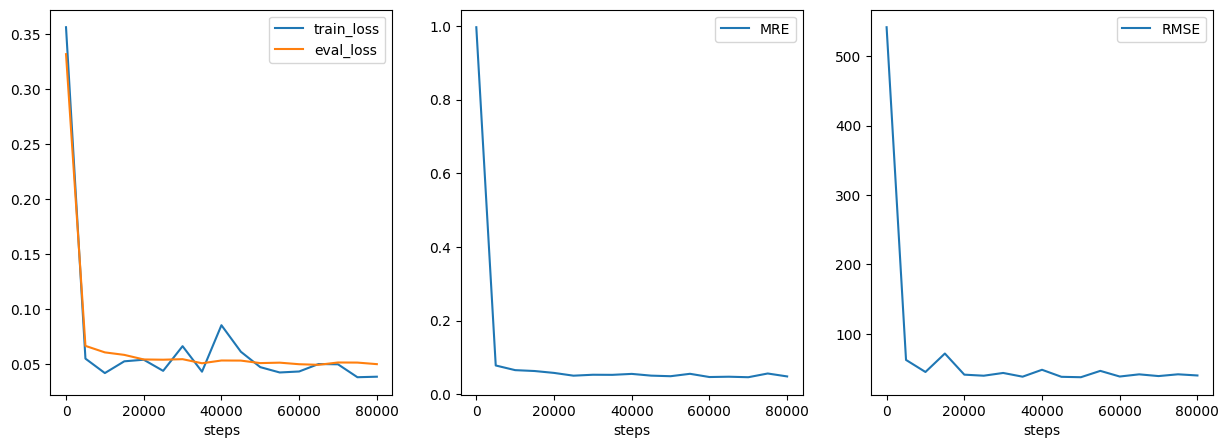

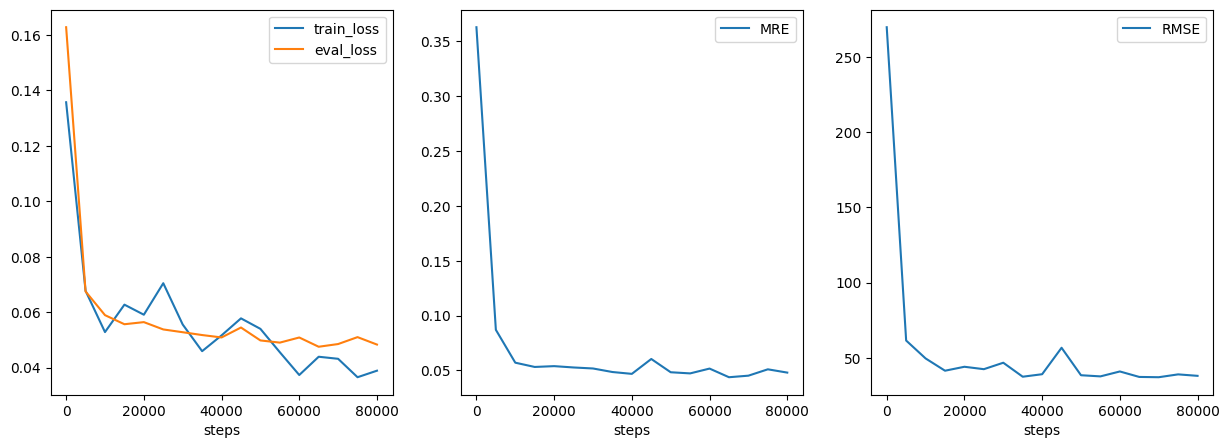

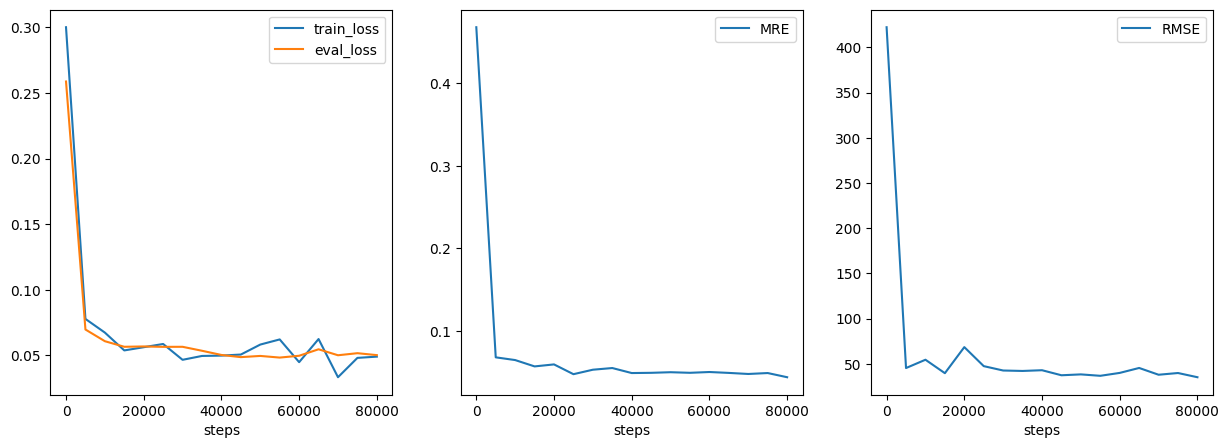

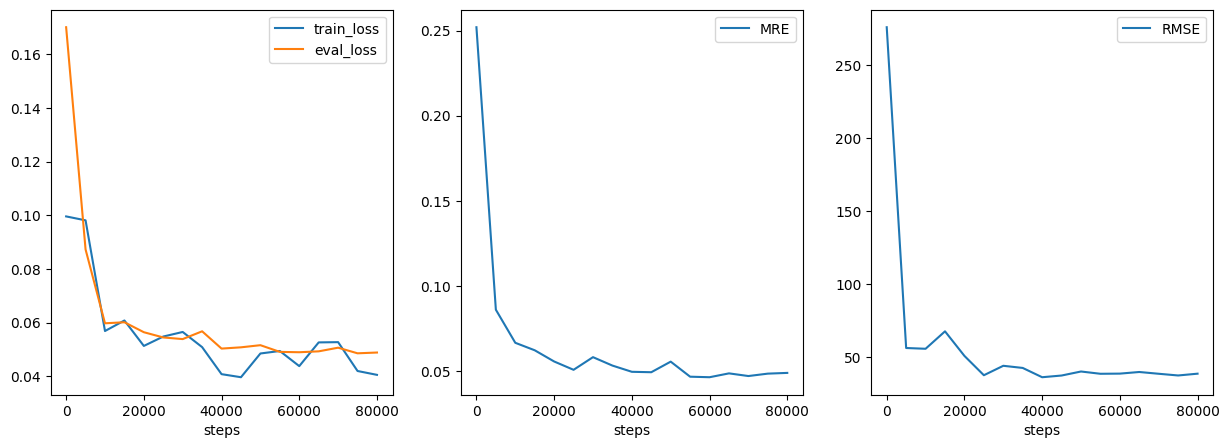

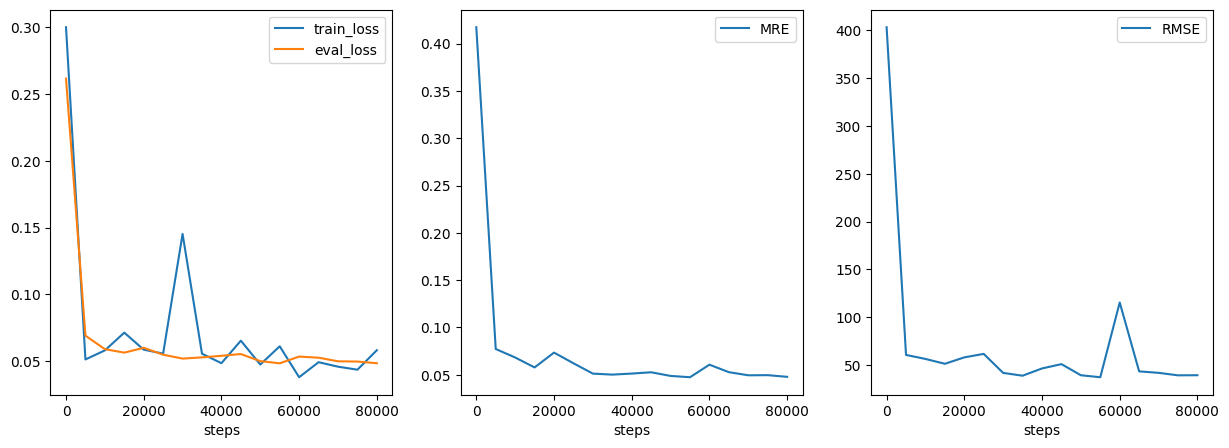

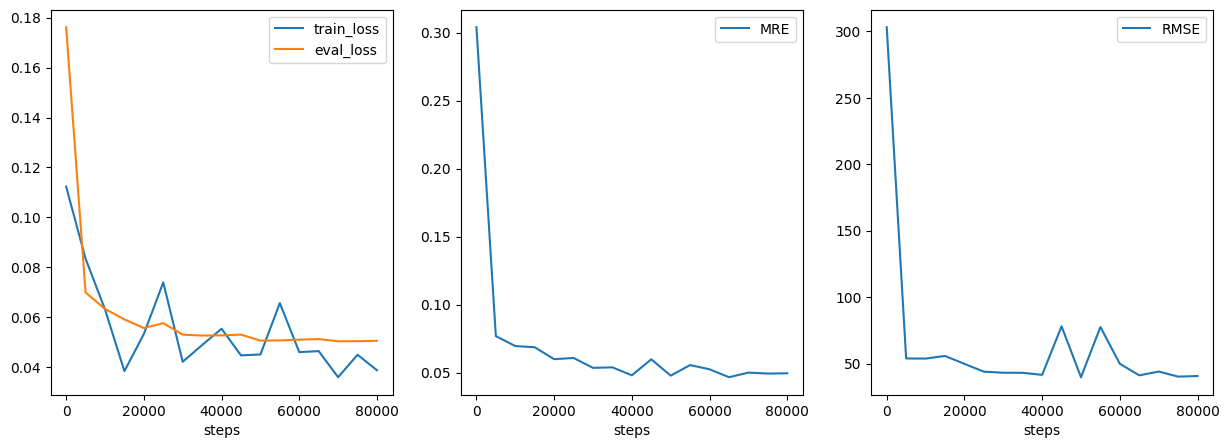

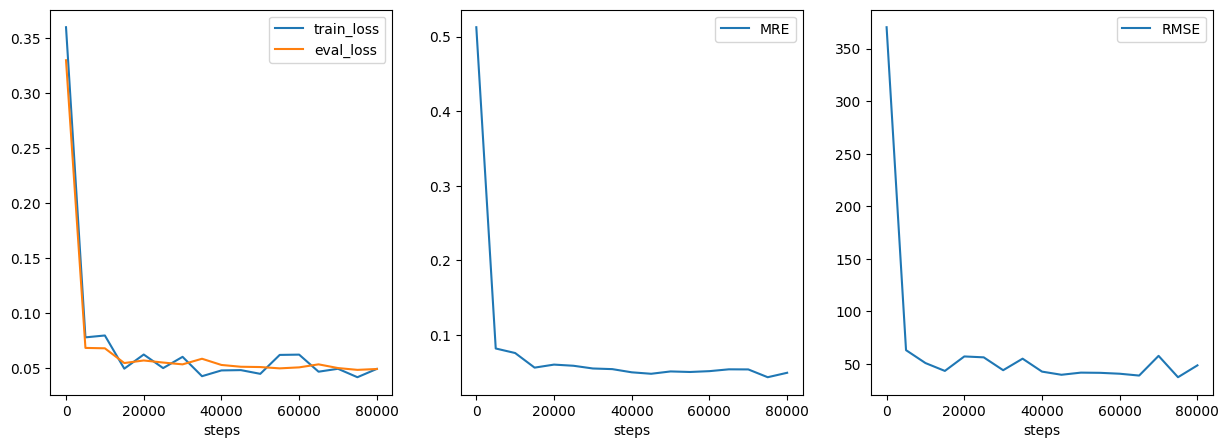

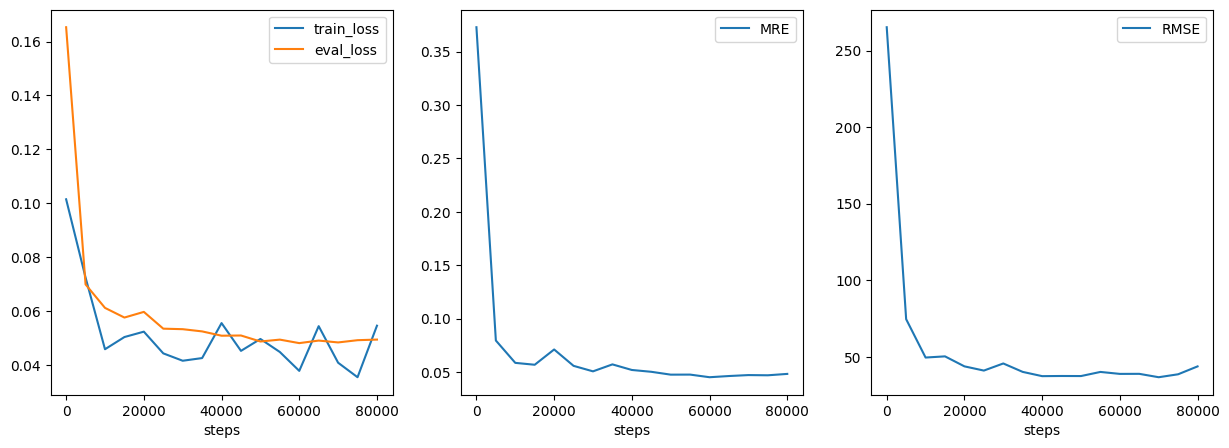

In [10]:

# for i in range(len(transfer_configs)):
#     conf = Config.from_dict({
#         "model": "LSTM",
#         "dataset_environment_str": dataset_environment_str,
#         "meta_dataset_environment_strs": [dataset_environment_str],
#         "dataset_subgraph_node_size": 12,
#         "dataset_subgraph_step": 3,
#         "all_seed": 42,
#         "dataset_params": {
#             "duration_summed": False,
#         },
#         "model_params": {
#             "num_layers": 4,
#             "bidirectional": True
#         },
#         "dataset_dummy": False,
#         "batch_size": 128,
#         "eval_steps": eval_step,
#         "learning_rate": 0.001,
#         "epochs": epoch,
#         "optimizer": "Adam",
#         "train_size": train_size,
#         "eval_size": eval_size,
#         "transfer_params": transfer_configs[i],
#         "meta_configs": {
#             "learning_rate": 0.005,
#             "meta_learning_rate": 0.001,
#             "meta_train_steps": 1000,
#             "meta_task_per_step": 8,
#             "meta_fast_adaption_step": 5,
#             "meta_dataset_train_environment_strs": [dataset_environment_str],
#             "meta_dataset_eval_environment_strs": [dataset_environment_str],
#         },
#     })

#     model = torch.load(meta_model_path)
#     print(model)
#     model_type = ModelType.LSTM
#     single_train_loop(model_type, conf, preprocessed_train_ds,
#                       preprocessed_eval_ds, model, compute_evaluate_metrics, to_device, suffix="transfer")

In [ ]:
train_sizes = [10000, 50000, 100000, 150000, 200000, 250000, 300000]
epoches = [300, 200, 100, 75, 75, 50, 50]
eval_steps = [2000, 2000, 3000, 3000, 5000, 5000, 5000]
for i in range(len(eval_steps)):
    train_size = train_sizes[i]
    epoch = epoches[i]
    eval_step = epoches[i]
    conf = Config.from_dict({
        "model": "LSTM",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size": 12,
        "dataset_subgraph_step": 3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 4,
            "bidirectional": True
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": eval_step,
        "learning_rate": 0.001,
        "epochs": epoch,
        "optimizer": "Adam",
        "train_size": train_size,
        "eval_size": eval_size,
        "transfer_params": transfer_configs[0],
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    })

    eval_graphs = load_graphs(dataset_environment_str,
                              train_or_eval="eval",
                              use_dummy=dummy,
                              max_row=eval_size)
    train_graphs = load_graphs(dataset_environment_str,
                               train_or_eval="train",
                               use_dummy=dummy,
                               max_row=train_size)  # todo 500
    print(len(train_graphs), len(eval_graphs))
    train_ds = init_dataset(train_graphs, conf)
    eval_ds = init_dataset(eval_graphs, conf)
    scalers = get_scalers(train_ds)
    preprocessed_train_ds = preprocess_dataset(train_ds, scalers)
    preprocessed_eval_ds = preprocess_dataset(eval_ds, scalers)
    model = torch.load(meta_model_path)
    # model = init_LSTM_model()
    print(model)
    model_type = ModelType.LSTM
    single_train_loop(model_type, conf, preprocessed_train_ds,
                      preprocessed_eval_ds, model, compute_evaluate_metrics, to_device, suffix="transfer")